In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import seaborn as sns
from ExplainableMaximumLikelihoodCalculator import ExplainableMaximumLikelihoodCalculator
import pysam
from Bio import SeqIO, Seq, SeqRecord, pairwise2
from Bio.pairwise2 import format_alignment
from LoadDataUtils import getListOfReadsFromBamFile, getListOfReadsFromFastaFile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
import shap
from scipy.stats import chisquare
from scipy.special import rel_entr
fileNameSapiens =  "data/simulatedData/human_chinese_AF346973_500samples.fas" #File that contains 500 reads from homo sapiens
fileNameNeanderthals =  "data/simulatedData/Neanderthal_Goyet_KX198085_500samples.fas" #File that contains 500 reads from neanderthal
fileNameDenisovans =  "data/simulatedData/denisova_kx663333_500samples.fas" #File that contains 500 reads from denisovan
neanderthals_500_generated = getListOfReadsFromFastaFile(fileNameNeanderthals)
sapiens_500_generated = getListOfReadsFromFastaFile(fileNameSapiens)
denisovan_500_samples = getListOfReadsFromFastaFile(fileNameDenisovans)
path_to_frequencies_table = "data/substitution_matrix.tsv"
import itertools
 
def findsubsets(s, n):
    subsets = list(itertools.combinations(s, n))
    return [list(a) for a in subsets]

2023-08-16 22:09:44.002085: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-16 22:09:44.617114: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-16 22:09:45.022552: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-16 22:09:46.555977: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
sapiens_reference_file_names = [
                    "data/reference_files/human_AF346981_French.fa",
                     "data/reference_files/human_AY195760_Korea.fa",
                      "data/reference_files/human_AY882416_Ethiopia.fa",
                      "data/reference_files/human_AY963586_Italian.fa",
                      "data/reference_files/human_AY195781_Caucasian.fa",
                      "data/reference_files/human_AY195757_Iraqi-Israeli.fa",
                      "data/reference_files/human_AY195749_NativeAmerican.fa"]
neanderthals_reference_file_names = [
                            "data/reference_files/neanderthal_mezmaiskaya1_FM865411.fa",
                           "data/reference_files/Neanderthal_Altai_KC879692.fa",
                           "data/reference_files/Neanderthal_Denisova11_full_mtDNA_KU131206.fa",
                           "data/reference_files/Neanderthal_Spy_94a_MG025538.fa",
                            "data/reference_files/Neanderthal_Vindija33.16_AM948965.fa",
                            "data/reference_files/Neanderthal_Vindija33.19_KJ533545.fa"]
denisovan_reference_file_names = [  
                        "data/reference_files/Denisova_MT576653.1.fa",
                        "data/reference_files/Denisova_MT576652.1.fa",
                        "data/reference_files/Denisova_4_FR695060.fa",
                        "data/reference_files/Denisova_8_KT780370.fa",
                        "data/reference_files/Denisova_manual_phalanx_NC_013993.fa",
                        "data/reference_files/Denisova_MT576651.1.fa"]

In [3]:
def generate_sample(sap, nean, den):
    list_before =  list(np.random.choice(sapiens_500_generated, sap)) + list(np.random.choice(neanderthals_500_generated, nean)) + list(np.random.choice(denisovan_500_samples, den))
    l = []
    for i in list_before:
        l.append(str(i))
    return l

In [4]:
def get_counter_factual_based_on_shap(ml_estimtator, sample_size):
    
    shapleys = ml_estimtator.calculate_shapley_values(sample_size)
    cf = ml_estimtator.generateCounterFactualMinimalSetToRemoveAndChangeMax(shapleys)
    print(cf[0])
    size_of_cf = len(cf[0])
    return size_of_cf
    

In [5]:
def get_cf_based_on_a_s_d(ml_estimtator):
    cf = ml_estimtator.generateCounterFactualMinimalSetToRemoveAndChangeMax_using_a_s_d_values()
    print(cf[0])
    size_of_cf = len(cf[0])
    return size_of_cf
    

In [6]:
def get_counter_factual_based_on_monte_carlo(ml_estimtator, sample_size):
    
    shapley_values_monte_carlo = ml_estimtator.estimate_shapley_values(number_of_samples_per_read = sample_size)
    cf = ml_estimtator.generateCounterFactualMinimalSetToRemoveAndChangeMax(shapley_values_monte_carlo)
    print(cf[0])
    size_of_cf = len(cf[0])
    return size_of_cf
    

In [7]:
def calculate_ground_truth(ml_estimator, sample):
    maxer_before = ml_estimator.estimate_species_proportions().values.argmax()
    sample_indexes = [i for i in range(len(sample))]
    for i in range(len(sample)):
        print("working on size: ", i)
        subsets = findsubsets(sample_indexes, i)
        for to_ignore in subsets:
            result_after = ml_estimator.estimate_species_proportions(ignore_list_indexes=to_ignore).values.argmax()
            if (result_after != maxer_before):
                return (i, to_ignore)
    return (0, [])
        
    
    

In [8]:

results = []
number_of_experiments = 50
sample_sizes = [1,5,10,20,50,100,200,500]
for i in range(number_of_experiments):
    print("new experiment:", i)
    size_of_sample = 12
    number_of_sap = random.randint(0,size_of_sample-1)
    number_of_nean = ((size_of_sample-number_of_sap)*2)//3
    number_of_denisovan = size_of_sample - number_of_sap - number_of_nean
    print(number_of_sap, number_of_nean, number_of_denisovan)
    sample = generate_sample(number_of_sap, number_of_nean, number_of_denisovan)
    maximum_likelihood_calculator_on_sample = ExplainableMaximumLikelihoodCalculator(sample,
                                                ref_neanderthal_file_names=neanderthals_reference_file_names,
                                                ref_sapien_file_names=sapiens_reference_file_names,
                                                ref_denisovan_file_names=denisovan_reference_file_names,
                                                path_to_substitution_matrix=path_to_frequencies_table,
                                                number_of_jobs=-1)
    ground_truth = calculate_ground_truth(maximum_likelihood_calculator_on_sample, sample)
    print("groundtruth:", ground_truth[0])
    print("groundtruth values:", ground_truth[1])
    if (ground_truth[0] == size_of_sample):
        continue
    shap_results = []
    mc_results = []
    for sample in sample_sizes:
        
        size_of_cf_monte_carlo = get_counter_factual_based_on_monte_carlo(maximum_likelihood_calculator_on_sample, sample)
        mc_results.append((sample, size_of_cf_monte_carlo))
        print(f"counter_factual monte carlo on size {sample}:", size_of_cf_monte_carlo)

        size_of_cf_shap = get_counter_factual_based_on_shap(maximum_likelihood_calculator_on_sample, sample)
        shap_results.append((sample, size_of_cf_shap))
        print(f"counter_factual shap on size {sample}:", size_of_cf_shap)
    
    size_of_cf_based_on_a_s_d = get_cf_based_on_a_s_d(maximum_likelihood_calculator_on_sample)
    print("counter_factualA_s_d:", size_of_cf_based_on_a_s_d)

    results.append((number_of_sap, number_of_nean, number_of_denisovan, ground_truth[0], shap_results, mc_results, size_of_cf_based_on_a_s_d))
    print(results)
    
    

new experiment: 0
10 1 1
Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  12
start working on read number 0
working on size:  0
working on size:  1
working on size:  2
working on size:  3
working on size:  4
working on size:  5
working on size:  6
groundtruth: 6
groundtruth values: [0, 2, 4, 6, 8, 9]
Change dominating species from Homo Sapiens to Neanderthal would require removing 9 reads: [6, 8, 9, 10, 0, 1, 2, 3, 4]
[6, 8, 9, 10, 0, 1, 2, 3, 4]
counter_factual monte carlo on size 1: 9
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Homo Sapiens to Denisovan would require removing 10 reads: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
counter_factual shap on size 1: 10
Change dominating species from Homo Sapiens to Neanderthal would require removing 6 reads: [4, 2, 0, 9, 6, 8]
[4, 2, 0, 9, 6, 8]
counter_factual monte carlo on size 5: 6
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Homo Sapiens to Denisovan would require removing 10 reads: [1, 0, 2, 3, 4, 5, 6, 7, 8, 9]
[1, 0, 2, 3, 4, 5, 6, 7, 8, 9]
counter_factual shap on size 5: 10
Change dominating species from Homo Sapiens to Neanderthal would require removing 8 reads: [6, 8, 4, 3, 10, 0, 9, 2]
[6, 8, 4, 3, 10, 0, 9, 2]
counter_factual monte carlo on size 10: 8
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Homo Sapiens to Denisovan would require removing 10 reads: [1, 6, 2, 0, 3, 4, 5, 7, 8, 9]
[1, 6, 2, 0, 3, 4, 5, 7, 8, 9]
counter_factual shap on size 10: 10
Change dominating species from Homo Sapiens to Neanderthal would require removing 6 reads: [4, 2, 6, 8, 9, 0]
[4, 2, 6, 8, 9, 0]
counter_factual monte carlo on size 20: 6
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Homo Sapiens to Denisovan would require removing 11 reads: [3, 4, 2, 0, 1, 5, 6, 7, 9, 10, 8]
[3, 4, 2, 0, 1, 5, 6, 7, 9, 10, 8]
counter_factual shap on size 20: 11
Change dominating species from Homo Sapiens to Denisovan would require removing 7 reads: [2, 8, 6, 9, 4, 5, 3]
[2, 8, 6, 9, 4, 5, 3]
counter_factual monte carlo on size 50: 7
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Homo Sapiens to Neanderthal would require removing 7 reads: [2, 6, 8, 9, 4, 5, 0]
[2, 6, 8, 9, 4, 5, 0]
counter_factual shap on size 50: 7
Change dominating species from Homo Sapiens to Neanderthal would require removing 7 reads: [8, 6, 2, 4, 9, 5, 0]
[8, 6, 2, 4, 9, 5, 0]
counter_factual monte carlo on size 100: 7
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Homo Sapiens to Neanderthal would require removing 6 reads: [4, 2, 8, 6, 9, 0]
[4, 2, 8, 6, 9, 0]
counter_factual shap on size 100: 6
Change dominating species from Homo Sapiens to Neanderthal would require removing 7 reads: [8, 2, 4, 9, 6, 5, 0]
[8, 2, 4, 9, 6, 5, 0]
counter_factual monte carlo on size 200: 7
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Homo Sapiens to Neanderthal would require removing 6 reads: [8, 6, 2, 4, 9, 0]
[8, 6, 2, 4, 9, 0]
counter_factual shap on size 200: 6
Change dominating species from Homo Sapiens to Neanderthal would require removing 7 reads: [8, 2, 4, 9, 6, 5, 0]
[8, 2, 4, 9, 6, 5, 0]
counter_factual monte carlo on size 500: 7
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Homo Sapiens to Neanderthal would require removing 7 reads: [4, 9, 8, 2, 6, 5, 0]
[4, 9, 8, 2, 6, 5, 0]
counter_factual shap on size 500: 7
Change dominating species from Homo Sapiens to Denisovan would require removing 7 reads: [6, 4, 9, 8, 2, 5, 3]
[6, 4, 9, 8, 2, 5, 3]
counter_factualA_s_d: 7
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7)]
new experiment: 1
5 4 3
Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  12
start working on read number 0
working on size:  0
working on size:  1
working on size:  2
working on size:  3
groundtruth: 3
groundtruth values: [2, 3, 4]
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [3, 2, 7, 4]
[3, 2, 7, 4]
counter_factual monte carlo on size 1: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Homo Sapiens to Neanderthal would require removing 5 reads: [0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
counter_factual shap on size 1: 5
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [3, 4, 9]
[3, 4, 9]
counter_factual monte carlo on size 5: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Homo Sapiens to Neanderthal would require removing 5 reads: [3, 0, 1, 2, 4]
[3, 0, 1, 2, 4]
counter_factual shap on size 5: 5
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [9, 4, 3]
[9, 4, 3]
counter_factual monte carlo on size 10: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Homo Sapiens to Neanderthal would require removing 5 reads: [0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
counter_factual shap on size 10: 5
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [3, 4, 2]
[3, 4, 2]
counter_factual monte carlo on size 20: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Homo Sapiens to Neanderthal would require removing 5 reads: [2, 9, 0, 1, 3]
[2, 9, 0, 1, 3]
counter_factual shap on size 20: 5
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [4, 3, 2]
[4, 3, 2]
counter_factual monte carlo on size 50: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [2, 3, 4]
[2, 3, 4]
counter_factual shap on size 50: 3
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [3, 2, 4]
[3, 2, 4]
counter_factual monte carlo on size 100: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [3, 4, 2]
[3, 4, 2]
counter_factual shap on size 100: 3
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [4, 2, 3]
[4, 2, 3]
counter_factual monte carlo on size 200: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [2, 3, 4]
[2, 3, 4]
counter_factual shap on size 200: 3
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [4, 2, 3]
[4, 2, 3]
counter_factual monte carlo on size 500: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [3, 4, 2]
[3, 4, 2]
counter_factual shap on size 500: 3
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [3, 4, 2]
[3, 4, 2]
counter_factualA_s_d: 3
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3)]
new experiment: 2
2 6 4
Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  12
start working on read number 0
working on size:  0
working on size:  1
groundtruth: 1
groundtruth values: [4]
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [3, 5, 4]
[3, 5, 4]
counter_factual mont

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [0, 1, 2]
[0, 1, 2]
counter_factual shap on size 1: 3
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [4]
[4]
counter_factual monte carlo on size 5: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [0, 1, 2]
[0, 1, 2]
counter_factual shap on size 5: 3
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [4]
[4]
counter_factual monte carlo on size 10: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Neanderthal to Denisovan would require removing 2 reads: [2, 0]
[2, 0]
counter_factual shap on size 10: 2
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [4]
[4]
counter_factual monte carlo on size 20: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [4]
[4]
counter_factual shap on size 20: 1
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [4]
[4]
counter_factual monte carlo on size 50: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [4]
[4]
counter_factual shap on size 50: 1
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [4]
[4]
counter_factual monte carlo on size 100: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [4]
[4]
counter_factual shap on size 100: 1
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [4]
[4]
counter_factual monte carlo on size 200: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [4]
[4]
counter_factual shap on size 200: 1
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [4]
[4]
counter_factual monte carlo on size 500: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [4]
[4]
counter_factual shap on size 500: 1
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [4]
[4]
counter_factualA_s_d: 1
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1)]
new experiment: 3
4 5 3
Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  12
start working on read number 0
working on size:  0
working on size:  1
working on size:  2
groundtrut

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [0, 1, 2]
[0, 1, 2]
counter_factual shap on size 1: 3
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [2, 3]
[2, 3]
counter_factual monte carlo on size 5: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [2, 0]
[2, 0]
counter_factual shap on size 5: 2
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [0, 3]
[0, 3]
counter_factual monte carlo on size 10: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [2, 0]
[2, 0]
counter_factual shap on size 10: 2
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [3, 0]
[3, 0]
counter_factual monte carlo on size 20: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [3, 2]
[3, 2]
counter_factual shap on size 20: 2
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [2, 0]
[2, 0]
counter_factual monte carlo on size 50: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [2, 0]
[2, 0]
counter_factual shap on size 50: 2
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [2, 3]
[2, 3]
counter_factual monte carlo on size 100: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [0, 3]
[0, 3]
counter_factual shap on size 100: 2
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [2, 3]
[2, 3]
counter_factual monte carlo on size 200: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [0, 3]
[0, 3]
counter_factual shap on size 200: 2
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [2, 0]
[2, 0]
counter_factual monte carlo on size 500: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [3, 2]
[3, 2]
counter_factual shap on size 500: 2
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [3, 0]
[3, 0]
counter_factualA_s_d: 2
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2)]
new experiment: 4
9 2 1
Loading sequences and calc

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Homo Sapiens to Neanderthal would require removing 8 reads: [0, 1, 2, 3, 4, 5, 6, 7]
[0, 1, 2, 3, 4, 5, 6, 7]
counter_factual shap on size 1: 8
Change dominating species from Homo Sapiens to Neanderthal would require removing 6 reads: [10, 5, 2, 3, 6, 7]
[10, 5, 2, 3, 6, 7]
counter_factual monte carlo on size 5: 6
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Homo Sapiens to Neanderthal would require removing 7 reads: [7, 0, 1, 2, 3, 4, 5]
[7, 0, 1, 2, 3, 4, 5]
counter_factual shap on size 5: 7
Change dominating species from Homo Sapiens to Neanderthal would require removing 5 reads: [1, 5, 10, 4, 7]
[1, 5, 10, 4, 7]
counter_factual monte carlo on size 10: 5
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Homo Sapiens to Neanderthal would require removing 7 reads: [11, 0, 7, 1, 2, 3, 5]
[11, 0, 7, 1, 2, 3, 5]
counter_factual shap on size 10: 7
Change dominating species from Homo Sapiens to Neanderthal would require removing 5 reads: [2, 5, 10, 4, 7]
[2, 5, 10, 4, 7]
counter_factual monte carlo on size 20: 5
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Homo Sapiens to Neanderthal would require removing 9 reads: [10, 1, 2, 3, 0, 4, 5, 6, 7]
[10, 1, 2, 3, 0, 4, 5, 6, 7]
counter_factual shap on size 20: 9
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [5, 2, 4, 7]
[5, 2, 4, 7]
counter_factual monte carlo on size 50: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Homo Sapiens to Neanderthal would require removing 5 reads: [7, 5, 10, 8, 2]
[7, 5, 10, 8, 2]
counter_factual shap on size 50: 5
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [7, 5, 1, 4]
[7, 5, 1, 4]
counter_factual monte carlo on size 100: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Homo Sapiens to Neanderthal would require removing 5 reads: [5, 7, 10, 1, 4]
[5, 7, 10, 1, 4]
counter_factual shap on size 100: 5
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [5, 7, 1, 4]
[5, 7, 1, 4]
counter_factual monte carlo on size 200: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Homo Sapiens to Neanderthal would require removing 6 reads: [5, 7, 10, 3, 1, 2]
[5, 7, 10, 3, 1, 2]
counter_factual shap on size 200: 6
Change dominating species from Homo Sapiens to Neanderthal would require removing 5 reads: [7, 5, 1, 10, 2]
[7, 5, 1, 10, 2]
counter_factual monte carlo on size 500: 5
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Homo Sapiens to Neanderthal would require removing 5 reads: [5, 7, 1, 10, 4]
[5, 7, 1, 10, 4]
counter_factual shap on size 500: 5
Change dominating species from Homo Sapiens to Neanderthal would require removing 6 reads: [7, 5, 1, 10, 6, 2]
[7, 5, 1, 10, 6, 2]
counter_factualA_s_d: 6
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Homo Sapiens to Neanderthal would require removing 5 reads: [0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
counter_factual shap on size 1: 5
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [5, 0]
[5, 0]
counter_factual monte carlo on size 5: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Homo Sapiens to Neanderthal would require removing 5 reads: [1, 0, 2, 3, 4]
[1, 0, 2, 3, 4]
counter_factual shap on size 5: 5
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [8, 5]
[8, 5]
counter_factual monte carlo on size 10: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [8, 2, 0]
[8, 2, 0]
counter_factual shap on size 10: 3
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [5, 4]
[5, 4]
counter_factual monte carlo on size 20: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [4, 0]
[4, 0]
counter_factual shap on size 20: 2
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [5, 0]
[5, 0]
counter_factual monte carlo on size 50: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [0, 4]
[0, 4]
counter_factual shap on size 50: 2
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [0, 5]
[0, 5]
counter_factual monte carlo on size 100: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [0, 4]
[0, 4]
counter_factual shap on size 100: 2
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [5, 0]
[5, 0]
counter_factual monte carlo on size 200: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [0, 5]
[0, 5]
counter_factual shap on size 200: 2
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [5, 4]
[5, 4]
counter_factual monte carlo on size 500: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [0, 5]
[0, 5]
counter_factual shap on size 500: 2
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [4, 5]
[4, 5]
counter_factualA_s_d: 2
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5, 7), (10, 7), (20, 9), (5

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [0, 1, 2, 3]
[0, 1, 2, 3]
counter_factual shap on size 1: 4
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [3, 1, 2]
[3, 1, 2]
counter_factual monte carlo on size 5: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Homo Sapiens to Neanderthal would require removing 5 reads: [5, 0, 1, 2, 3]
[5, 0, 1, 2, 3]
counter_factual shap on size 5: 5
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [3, 4, 5, 2]
[3, 4, 5, 2]
counter_factual monte carlo on size 10: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [3, 1, 0, 2]
[3, 1, 0, 2]
counter_factual shap on size 10: 4
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [3, 2, 1]
[3, 2, 1]
counter_factual monte carlo on size 20: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Homo Sapiens to Neanderthal would require removing 5 reads: [8, 1, 0, 2, 3]
[8, 1, 0, 2, 3]
counter_factual shap on size 20: 5
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [4, 3, 2]
[4, 3, 2]
counter_factual monte carlo on size 50: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [3, 2, 1]
[3, 2, 1]
counter_factual shap on size 50: 3
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [4, 3, 2]
[4, 3, 2]
counter_factual monte carlo on size 100: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [1, 2, 4]
[1, 2, 4]
counter_factual shap on size 100: 3
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [4, 3, 2]
[4, 3, 2]
counter_factual monte carlo on size 200: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [1, 4, 3]
[1, 4, 3]
counter_factual shap on size 200: 3
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [1, 3, 2]
[1, 3, 2]
counter_factual monte carlo on size 500: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [4, 2, 3]
[4, 2, 3]
counter_factual shap on size 500: 3
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [3, 4, 2]
[3, 4, 2]
counter_factualA_s_d: 3
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5, 7), (10, 7),

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Neanderthal to Denisovan would require removing 6 reads: [0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
counter_factual shap on size 1: 6
Change dominating species from Neanderthal to Denisovan would require removing 4 reads: [5, 4, 6, 2]
[5, 4, 6, 2]
counter_factual monte carlo on size 5: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Neanderthal to Denisovan would require removing 6 reads: [2, 0, 1, 3, 4, 5]
[2, 0, 1, 3, 4, 5]
counter_factual shap on size 5: 6
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [5, 2, 4]
[5, 2, 4]
counter_factual monte carlo on size 10: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Neanderthal to Denisovan would require removing 6 reads: [5, 0, 1, 2, 3, 4]
[5, 0, 1, 2, 3, 4]
counter_factual shap on size 10: 6
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [2, 5, 4]
[2, 5, 4]
counter_factual monte carlo on size 20: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Neanderthal to Denisovan would require removing 5 reads: [6, 5, 4, 0, 2]
[6, 5, 4, 0, 2]
counter_factual shap on size 20: 5
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [6, 2, 5]
[6, 2, 5]
counter_factual monte carlo on size 50: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [5, 2, 4]
[5, 2, 4]
counter_factual shap on size 50: 3
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [5, 6, 2]
[5, 6, 2]
counter_factual monte carlo on size 100: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [2, 5, 6]
[2, 5, 6]
counter_factual shap on size 100: 3
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [6, 5, 2]
[6, 5, 2]
counter_factual monte carlo on size 200: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [5, 2, 6]
[5, 2, 6]
counter_factual shap on size 200: 3
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [6, 2, 5]
[6, 2, 5]
counter_factual monte carlo on size 500: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [5, 6, 2]
[5, 6, 2]
counter_factual shap on size 500: 3
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [2, 5, 6]
[2, 5, 6]
counter_factualA_s_d: 3
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5, 7), (10, 7), (20, 

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Neanderthal to Denisovan would require removing 5 reads: [0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
counter_factual shap on size 1: 5
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [6, 2, 3]
[6, 2, 3]
counter_factual monte carlo on size 5: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Neanderthal to Denisovan would require removing 5 reads: [5, 0, 1, 2, 3]
[5, 0, 1, 2, 3]
counter_factual shap on size 5: 5
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [6, 5, 3]
[6, 5, 3]
counter_factual monte carlo on size 10: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Neanderthal to Denisovan would require removing 7 reads: [7, 10, 0, 1, 2, 3, 4]
[7, 10, 0, 1, 2, 3, 4]
counter_factual shap on size 10: 7
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [5, 2, 6]
[5, 2, 6]
counter_factual monte carlo on size 20: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Neanderthal to Denisovan would require removing 4 reads: [4, 3, 7, 5]
[4, 3, 7, 5]
counter_factual shap on size 20: 4
Change dominating species from Neanderthal to Denisovan would require removing 4 reads: [2, 3, 7, 6]
[2, 3, 7, 6]
counter_factual monte carlo on size 50: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Neanderthal to Denisovan would require removing 4 reads: [3, 2, 7, 6]
[3, 2, 7, 6]
counter_factual shap on size 50: 4
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [5, 6, 2]
[5, 6, 2]
counter_factual monte carlo on size 100: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [3, 6, 5]
[3, 6, 5]
counter_factual shap on size 100: 3
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [5, 3, 2]
[5, 3, 2]
counter_factual monte carlo on size 200: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [5, 2, 3]
[5, 2, 3]
counter_factual shap on size 200: 3
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [3, 6, 2]
[3, 6, 2]
counter_factual monte carlo on size 500: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [5, 2, 3]
[5, 2, 3]
counter_factual shap on size 500: 3
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [2, 5, 3]
[2, 5, 3]
counter_factualA_s_d: 3
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5, 7), (10, 7), (20, 

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [0, 1, 2, 3]
[0, 1, 2, 3]
counter_factual shap on size 1: 4
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [2, 1, 3, 0]
[2, 1, 3, 0]
counter_factual monte carlo on size 5: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [2, 7, 0, 1]
[2, 7, 0, 1]
counter_factual shap on size 5: 4
Change dominating species from Homo Sapiens to Neanderthal would require removing 5 reads: [0, 2, 7, 9, 1]
[0, 2, 7, 9, 1]
counter_factual monte carlo on size 10: 5
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [0, 1, 2, 3]
[0, 1, 2, 3]
counter_factual shap on size 10: 4
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [1, 2, 0, 9]
[1, 2, 0, 9]
counter_factual monte carlo on size 20: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Homo Sapiens to Denisovan would require removing 6 reads: [2, 7, 5, 0, 3, 1]
[2, 7, 5, 0, 3, 1]
counter_factual shap on size 20: 6
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [2, 1, 0, 7]
[2, 1, 0, 7]
counter_factual monte carlo on size 50: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [2, 1, 7, 0]
[2, 1, 7, 0]
counter_factual shap on size 50: 4
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [0, 7, 1, 2]
[0, 7, 1, 2]
counter_factual monte carlo on size 100: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [0, 2, 1, 9]
[0, 2, 1, 9]
counter_factual shap on size 100: 4
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [2, 0, 1, 7]
[2, 0, 1, 7]
counter_factual monte carlo on size 200: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [1, 0, 2, 7]
[1, 0, 2, 7]
counter_factual shap on size 200: 4
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [2, 0, 7, 1]
[2, 0, 7, 1]
counter_factual monte carlo on size 500: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [1, 0, 2, 7]
[1, 0, 2, 7]
counter_factual shap on size 500: 4
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [1, 0, 2, 7]
[1, 0, 2, 7]
counter_factualA_s_d: 4
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5, 7), 

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [0, 1]
[0, 1]
counter_factual shap on size 1: 2
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [2, 1]
[2, 1]
counter_factual monte carlo on size 5: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [0, 1]
[0, 1]
counter_factual shap on size 5: 2
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [2, 1]
[2, 1]
counter_factual monte carlo on size 10: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [1, 0]
[1, 0]
counter_factual shap on size 10: 2
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [1, 2]
[1, 2]
counter_factual monte carlo on size 20: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [0, 1]
[0, 1]
counter_factual shap on size 20: 2
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [1, 2]
[1, 2]
counter_factual monte carlo on size 50: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [2, 1]
[2, 1]
counter_factual shap on size 50: 2
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [2, 1]
[2, 1]
counter_factual monte carlo on size 100: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [1, 2]
[1, 2]
counter_factual shap on size 100: 2
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [1, 2]
[1, 2]
counter_factual monte carlo on size 200: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [1, 2]
[1, 2]
counter_factual shap on size 200: 2
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [1, 2]
[1, 2]
counter_factual monte carlo on size 500: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [2, 1]
[2, 1]
counter_factual shap on size 500: 2
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [1, 2]
[1, 2]
counter_factualA_s_d: 2
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5, 7), (10, 7), (20, 9), (5

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Neanderthal to Denisovan would require removing 8 reads: [0, 1, 2, 3, 4, 5, 6, 7]
[0, 1, 2, 3, 4, 5, 6, 7]
counter_factual shap on size 1: 8
Change dominating species from Neanderthal to Homo Sapiens would require removing 6 reads: [6, 3, 0, 2, 8, 7]
[6, 3, 0, 2, 8, 7]
counter_factual monte carlo on size 5: 6
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Neanderthal to Homo Sapiens would require removing 6 reads: [8, 7, 0, 1, 2, 3]
[8, 7, 0, 1, 2, 3]
counter_factual shap on size 5: 6
Change dominating species from Neanderthal to Homo Sapiens would require removing 5 reads: [3, 8, 2, 0, 7]
[3, 8, 2, 0, 7]
counter_factual monte carlo on size 10: 5
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Neanderthal to Denisovan would require removing 8 reads: [6, 4, 2, 0, 1, 3, 5, 7]
[6, 4, 2, 0, 1, 3, 5, 7]
counter_factual shap on size 10: 8
Change dominating species from Neanderthal to Homo Sapiens would require removing 4 reads: [3, 7, 8, 2]
[3, 7, 8, 2]
counter_factual monte carlo on size 20: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Neanderthal to Denisovan would require removing 8 reads: [8, 1, 2, 0, 3, 4, 6, 7]
[8, 1, 2, 0, 3, 4, 6, 7]
counter_factual shap on size 20: 8
Change dominating species from Neanderthal to Homo Sapiens would require removing 4 reads: [2, 7, 3, 8]
[2, 7, 3, 8]
counter_factual monte carlo on size 50: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Neanderthal to Homo Sapiens would require removing 4 reads: [3, 8, 2, 7]
[3, 8, 2, 7]
counter_factual shap on size 50: 4
Change dominating species from Neanderthal to Homo Sapiens would require removing 4 reads: [2, 7, 3, 8]
[2, 7, 3, 8]
counter_factual monte carlo on size 100: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Neanderthal to Homo Sapiens would require removing 4 reads: [7, 8, 3, 2]
[7, 8, 3, 2]
counter_factual shap on size 100: 4
Change dominating species from Neanderthal to Homo Sapiens would require removing 4 reads: [7, 8, 2, 3]
[7, 8, 2, 3]
counter_factual monte carlo on size 200: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Neanderthal to Homo Sapiens would require removing 4 reads: [7, 3, 2, 8]
[7, 3, 2, 8]
counter_factual shap on size 200: 4
Change dominating species from Neanderthal to Homo Sapiens would require removing 4 reads: [2, 3, 8, 7]
[2, 3, 8, 7]
counter_factual monte carlo on size 500: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Neanderthal to Homo Sapiens would require removing 4 reads: [2, 7, 3, 8]
[2, 7, 3, 8]
counter_factual shap on size 500: 4
Change dominating species from Neanderthal to Homo Sapiens would require removing 4 reads: [7, 8, 3, 2]
[7, 8, 3, 2]
counter_factualA_s_d: 4
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5, 

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Neanderthal to Denisovan would require removing 8 reads: [0, 1, 2, 3, 4, 5, 6, 7]
[0, 1, 2, 3, 4, 5, 6, 7]
counter_factual shap on size 1: 8
Change dominating species from Neanderthal to Homo Sapiens would require removing 5 reads: [5, 11, 7, 8, 6]
[5, 11, 7, 8, 6]
counter_factual monte carlo on size 5: 5
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Neanderthal to Denisovan would require removing 8 reads: [2, 0, 1, 3, 4, 5, 6, 7]
[2, 0, 1, 3, 4, 5, 6, 7]
counter_factual shap on size 5: 8
Change dominating species from Neanderthal to Homo Sapiens would require removing 5 reads: [7, 5, 11, 8, 6]
[7, 5, 11, 8, 6]
counter_factual monte carlo on size 10: 5
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Neanderthal to Denisovan would require removing 8 reads: [5, 0, 1, 2, 3, 4, 6, 7]
[5, 0, 1, 2, 3, 4, 6, 7]
counter_factual shap on size 10: 8
Change dominating species from Neanderthal to Denisovan would require removing 4 reads: [8, 7, 6, 5]
[8, 7, 6, 5]
counter_factual monte carlo on size 20: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Neanderthal to Denisovan would require removing 4 reads: [6, 7, 8, 5]
[6, 7, 8, 5]
counter_factual shap on size 20: 4
Change dominating species from Neanderthal to Homo Sapiens would require removing 4 reads: [5, 6, 11, 7]
[5, 6, 11, 7]
counter_factual monte carlo on size 50: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Neanderthal to Denisovan would require removing 4 reads: [5, 8, 7, 6]
[5, 8, 7, 6]
counter_factual shap on size 50: 4
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [6, 7, 5]
[6, 7, 5]
counter_factual monte carlo on size 100: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Neanderthal to Denisovan would require removing 4 reads: [5, 0, 7, 6]
[5, 0, 7, 6]
counter_factual shap on size 100: 4
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [5, 6, 7]
[5, 6, 7]
counter_factual monte carlo on size 200: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [6, 5, 7]
[6, 5, 7]
counter_factual shap on size 200: 3
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [6, 5, 7]
[6, 5, 7]
counter_factual monte carlo on size 500: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [5, 6, 7]
[5, 6, 7]
counter_factual shap on size 500: 3
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [6, 5, 7]
[6, 5, 7]
counter_factualA_s_d: 3
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5, 7), (10, 7), (20, 

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Homo Sapiens to Denisovan would require removing 11 reads: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
counter_factual shap on size 1: 11
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [8, 3, 10, 6]
[8, 3, 10, 6]
counter_factual monte carlo on size 5: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Homo Sapiens to Denisovan would require removing 11 reads: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
counter_factual shap on size 5: 11
Change dominating species from Homo Sapiens to Denisovan would require removing 3 reads: [8, 10, 6]
[8, 10, 6]
counter_factual monte carlo on size 10: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Homo Sapiens to Denisovan would require removing 7 reads: [6, 2, 10, 0, 1, 3, 5]
[6, 2, 10, 0, 1, 3, 5]
counter_factual shap on size 10: 7
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [10, 8, 3, 6]
[10, 8, 3, 6]
counter_factual monte carlo on size 20: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Homo Sapiens to Neanderthal would require removing 8 reads: [8, 9, 0, 1, 2, 3, 5, 6]
[8, 9, 0, 1, 2, 3, 5, 6]
counter_factual shap on size 20: 8
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [10, 8, 3, 6]
[10, 8, 3, 6]
counter_factual monte carlo on size 50: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [8, 6, 3, 10]
[8, 6, 3, 10]
counter_factual shap on size 50: 4
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [3, 6, 10, 8]
[3, 6, 10, 8]
counter_factual monte carlo on size 100: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [10, 3, 6, 8]
[10, 3, 6, 8]
counter_factual shap on size 100: 4
Change dominating species from Homo Sapiens to Denisovan would require removing 3 reads: [6, 8, 10]
[6, 8, 10]
counter_factual monte carlo on size 200: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Homo Sapiens to Denisovan would require removing 3 reads: [6, 8, 10]
[6, 8, 10]
counter_factual shap on size 200: 3
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [10, 6, 3, 8]
[10, 6, 3, 8]
counter_factual monte carlo on size 500: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Homo Sapiens to Denisovan would require removing 3 reads: [6, 8, 10]
[6, 8, 10]
counter_factual shap on size 500: 3
Change dominating species from Homo Sapiens to Denisovan would require removing 3 reads: [8, 6, 10]
[8, 6, 10]
counter_factualA_s_d: 3
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5, 7), (10, 7),

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Neanderthal to Denisovan would require removing 9 reads: [0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
counter_factual shap on size 1: 9
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [6, 8]
[6, 8]
counter_factual monte carlo on size 5: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Neanderthal to Denisovan would require removing 8 reads: [2, 6, 1, 3, 4, 5, 7, 8]
[2, 6, 1, 3, 4, 5, 7, 8]
counter_factual shap on size 5: 8
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [8, 11]
[8, 11]
counter_factual monte carlo on size 10: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Neanderthal to Denisovan would require removing 9 reads: [4, 0, 1, 2, 3, 5, 6, 7, 8]
[4, 0, 1, 2, 3, 5, 6, 7, 8]
counter_factual shap on size 10: 9
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [6, 11]
[6, 11]
counter_factual monte carlo on size 20: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Neanderthal to Homo Sapiens would require removing 3 reads: [1, 11, 6]
[1, 11, 6]
counter_factual shap on size 20: 3
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [8, 6]
[8, 6]
counter_factual monte carlo on size 50: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Neanderthal to Homo Sapiens would require removing 4 reads: [8, 4, 5, 6]
[8, 4, 5, 6]
counter_factual shap on size 50: 4
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [8, 6]
[8, 6]
counter_factual monte carlo on size 100: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [8, 6]
[8, 6]
counter_factual shap on size 100: 2
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [8, 6]
[8, 6]
counter_factual monte carlo on size 200: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [8, 6]
[8, 6]
counter_factual shap on size 200: 2
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [8, 6]
[8, 6]
counter_factual monte carlo on size 500: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [6, 8]
[6, 8]
counter_factual shap on size 500: 2
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [6, 8]
[6, 8]
counter_factualA_s_d: 2
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5, 7), (10, 7), (20, 9), (5

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Neanderthal to Denisovan would require removing 5 reads: [0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
counter_factual shap on size 1: 5
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [5, 2, 6]
[5, 2, 6]
counter_factual monte carlo on size 5: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Neanderthal to Denisovan would require removing 6 reads: [10, 0, 1, 2, 3, 4]
[10, 0, 1, 2, 3, 4]
counter_factual shap on size 5: 6
Change dominating species from Neanderthal to Denisovan would require removing 4 reads: [2, 5, 1, 6]
[2, 5, 1, 6]
counter_factual monte carlo on size 10: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [2, 6, 1]
[2, 6, 1]
counter_factual shap on size 10: 3
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [6, 5, 2]
[6, 5, 2]
counter_factual monte carlo on size 20: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Neanderthal to Denisovan would require removing 4 reads: [6, 5, 4, 0]
[6, 5, 4, 0]
counter_factual shap on size 20: 4
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [6, 2, 5]
[6, 2, 5]
counter_factual monte carlo on size 50: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [2, 5, 6]
[2, 5, 6]
counter_factual shap on size 50: 3
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [2, 5, 6]
[2, 5, 6]
counter_factual monte carlo on size 100: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [2, 6, 5]
[2, 6, 5]
counter_factual shap on size 100: 3
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [6, 5, 2]
[6, 5, 2]
counter_factual monte carlo on size 200: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [2, 6, 5]
[2, 6, 5]
counter_factual shap on size 200: 3
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [6, 2, 5]
[6, 2, 5]
counter_factual monte carlo on size 500: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [2, 6, 5]
[2, 6, 5]
counter_factual shap on size 500: 3
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [2, 6, 5]
[2, 6, 5]
counter_factualA_s_d: 3
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5, 7), (10, 7), (20, 

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [0, 1, 2]
[0, 1, 2]
counter_factual shap on size 1: 3
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [5]
[5]
counter_factual monte carlo on size 5: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [5]
[5]
counter_factual shap on size 5: 1
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [5]
[5]
counter_factual monte carlo on size 10: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Neanderthal to Denisovan would require removing 2 reads: [4, 5]
[4, 5]
counter_factual shap on size 10: 2
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [5]
[5]
counter_factual monte carlo on size 20: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [2]
[2]
counter_factual shap on size 20: 1
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [2]
[2]
counter_factual monte carlo on size 50: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [5]
[5]
counter_factual shap on size 50: 1
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [5]
[5]
counter_factual monte carlo on size 100: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [5]
[5]
counter_factual shap on size 100: 1
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [5]
[5]
counter_factual monte carlo on size 200: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [2]
[2]
counter_factual shap on size 200: 1
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [5]
[5]
counter_factual monte carlo on size 500: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [5]
[5]
counter_factual shap on size 500: 1
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [2]
[2]
counter_factualA_s_d: 1
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5, 7), (10, 7), (20, 9), (50, 5), (100, 5), (

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Neanderthal to Denisovan would require removing 6 reads: [0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
counter_factual shap on size 1: 6
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [2, 6, 5]
[2, 6, 5]
counter_factual monte carlo on size 5: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Neanderthal to Denisovan would require removing 6 reads: [6, 0, 1, 2, 3, 4]
[6, 0, 1, 2, 3, 4]
counter_factual shap on size 5: 6
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [2, 4]
[2, 4]
counter_factual monte carlo on size 10: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Neanderthal to Denisovan would require removing 6 reads: [3, 2, 0, 1, 4, 5]
[3, 2, 0, 1, 4, 5]
counter_factual shap on size 10: 6
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [7, 2]
[7, 2]
counter_factual monte carlo on size 20: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [4, 7]
[4, 7]
counter_factual shap on size 20: 2
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [5, 2]
[5, 2]
counter_factual monte carlo on size 50: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [7, 5]
[7, 5]
counter_factual shap on size 50: 2
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [7, 4]
[7, 4]
counter_factual monte carlo on size 100: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [2, 5]
[2, 5]
counter_factual shap on size 100: 2
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [2, 4]
[2, 4]
counter_factual monte carlo on size 200: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [2, 5]
[2, 5]
counter_factual shap on size 200: 2
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [2, 4]
[2, 4]
counter_factual monte carlo on size 500: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [7, 4]
[7, 4]
counter_factual shap on size 500: 2
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [2, 4]
[2, 4]
counter_factualA_s_d: 2
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5, 7), (10, 7), (20, 9), (5

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Homo Sapiens to Denisovan would require removing 3 reads: [0, 1, 2]
[0, 1, 2]
counter_factual shap on size 1: 3
Change dominating species from Homo Sapiens to Denisovan would require removing 3 reads: [0, 4, 5]
[0, 4, 5]
counter_factual monte carlo on size 5: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Homo Sapiens to Denisovan would require removing 3 reads: [1, 0, 2]
[1, 0, 2]
counter_factual shap on size 5: 3
Change dominating species from Homo Sapiens to Denisovan would require removing 2 reads: [1, 2]
[1, 2]
counter_factual monte carlo on size 10: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Homo Sapiens to Denisovan would require removing 3 reads: [4, 0, 1]
[4, 0, 1]
counter_factual shap on size 10: 3
Change dominating species from Homo Sapiens to Denisovan would require removing 2 reads: [4, 2]
[4, 2]
counter_factual monte carlo on size 20: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Homo Sapiens to Denisovan would require removing 2 reads: [1, 4]
[1, 4]
counter_factual shap on size 20: 2
Change dominating species from Homo Sapiens to Denisovan would require removing 2 reads: [2, 4]
[2, 4]
counter_factual monte carlo on size 50: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Homo Sapiens to Denisovan would require removing 2 reads: [4, 1]
[4, 1]
counter_factual shap on size 50: 2
Change dominating species from Homo Sapiens to Denisovan would require removing 2 reads: [1, 4]
[1, 4]
counter_factual monte carlo on size 100: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Homo Sapiens to Denisovan would require removing 2 reads: [1, 2]
[1, 2]
counter_factual shap on size 100: 2
Change dominating species from Homo Sapiens to Denisovan would require removing 2 reads: [4, 1]
[4, 1]
counter_factual monte carlo on size 200: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Homo Sapiens to Denisovan would require removing 2 reads: [1, 2]
[1, 2]
counter_factual shap on size 200: 2
Change dominating species from Homo Sapiens to Denisovan would require removing 2 reads: [2, 1]
[2, 1]
counter_factual monte carlo on size 500: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Homo Sapiens to Denisovan would require removing 2 reads: [1, 2]
[1, 2]
counter_factual shap on size 500: 2
Change dominating species from Homo Sapiens to Denisovan would require removing 2 reads: [4, 2]
[4, 2]
counter_factualA_s_d: 2
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5, 7), (10, 7), (20, 9), (50, 5

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Neanderthal to Denisovan would require removing 4 reads: [0, 1, 2, 3]
[0, 1, 2, 3]
counter_factual shap on size 1: 4
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [4]
[4]
counter_factual monte carlo on size 5: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [5]
[5]
counter_factual shap on size 5: 1
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [4]
[4]
counter_factual monte carlo on size 10: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [4]
[4]
counter_factual shap on size 10: 1
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [4]
[4]
counter_factual monte carlo on size 20: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [5]
[5]
counter_factual shap on size 20: 1
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [4]
[4]
counter_factual monte carlo on size 50: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [4]
[4]
counter_factual shap on size 50: 1
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [4]
[4]
counter_factual monte carlo on size 100: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [4]
[4]
counter_factual shap on size 100: 1
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [4]
[4]
counter_factual monte carlo on size 200: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [4]
[4]
counter_factual shap on size 200: 1
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [4]
[4]
counter_factual monte carlo on size 500: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [4]
[4]
counter_factual shap on size 500: 1
Change dominating species from Neanderthal to Denisovan would require removing 1 reads: [4]
[4]
counter_factualA_s_d: 1
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5, 7), (10, 7), (20, 9), (50, 5), (100, 5), (

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Homo Sapiens to Neanderthal would require removing 7 reads: [0, 1, 2, 3, 4, 5, 6]
[0, 1, 2, 3, 4, 5, 6]
counter_factual shap on size 1: 7
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [7, 5]
[7, 5]
counter_factual monte carlo on size 5: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Homo Sapiens to Neanderthal would require removing 8 reads: [11, 0, 1, 2, 3, 4, 5, 6]
[11, 0, 1, 2, 3, 4, 5, 6]
counter_factual shap on size 5: 8
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [5, 6]
[5, 6]
counter_factual monte carlo on size 10: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [7, 0]
[7, 0]
counter_factual shap on size 10: 2
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [6, 5]
[6, 5]
counter_factual monte carlo on size 20: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [6, 5]
[6, 5]
counter_factual shap on size 20: 2
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [5, 7]
[5, 7]
counter_factual monte carlo on size 50: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [8, 0, 6]
[8, 0, 6]
counter_factual shap on size 50: 3
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [6, 7]
[6, 7]
counter_factual monte carlo on size 100: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [0, 7]
[0, 7]
counter_factual shap on size 100: 2
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [0, 6]
[0, 6]
counter_factual monte carlo on size 200: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [7, 6]
[7, 6]
counter_factual shap on size 200: 2
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [5, 6]
[5, 6]
counter_factual monte carlo on size 500: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [6, 7]
[6, 7]
counter_factual shap on size 500: 2
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [6, 5]
[6, 5]
counter_factualA_s_d: 2
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5, 7), (10, 7), (20, 9), (5

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Homo Sapiens to Neanderthal would require removing 10 reads: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
counter_factual shap on size 1: 10
Change dominating species from Homo Sapiens to Neanderthal would require removing 7 reads: [6, 9, 1, 7, 3, 4, 8]
[6, 9, 1, 7, 3, 4, 8]
counter_factual monte carlo on size 5: 7
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Homo Sapiens to Neanderthal would require removing 10 reads: [6, 0, 1, 2, 3, 4, 5, 7, 8, 9]
[6, 0, 1, 2, 3, 4, 5, 7, 8, 9]
counter_factual shap on size 5: 10
Change dominating species from Homo Sapiens to Neanderthal would require removing 7 reads: [8, 4, 6, 7, 1, 9, 3]
[8, 4, 6, 7, 1, 9, 3]
counter_factual monte carlo on size 10: 7
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Homo Sapiens to Neanderthal would require removing 9 reads: [1, 7, 6, 2, 3, 4, 5, 8, 9]
[1, 7, 6, 2, 3, 4, 5, 8, 9]
counter_factual shap on size 10: 9
Change dominating species from Homo Sapiens to Neanderthal would require removing 7 reads: [3, 6, 8, 9, 1, 4, 7]
[3, 6, 8, 9, 1, 4, 7]
counter_factual monte carlo on size 20: 7
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Homo Sapiens to Denisovan would require removing 10 reads: [0, 6, 7, 3, 8, 10, 2, 4, 9, 1]
[0, 6, 7, 3, 8, 10, 2, 4, 9, 1]
counter_factual shap on size 20: 10
Change dominating species from Homo Sapiens to Neanderthal would require removing 7 reads: [4, 6, 9, 7, 1, 8, 3]
[4, 6, 9, 7, 1, 8, 3]
counter_factual monte carlo on size 50: 7
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Homo Sapiens to Neanderthal would require removing 10 reads: [8, 9, 7, 3, 0, 1, 2, 4, 5, 6]
[8, 9, 7, 3, 0, 1, 2, 4, 5, 6]
counter_factual shap on size 50: 10
Change dominating species from Homo Sapiens to Neanderthal would require removing 7 reads: [8, 3, 9, 6, 7, 4, 1]
[8, 3, 9, 6, 7, 4, 1]
counter_factual monte carlo on size 100: 7
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Homo Sapiens to Neanderthal would require removing 7 reads: [8, 6, 7, 3, 9, 1, 4]
[8, 6, 7, 3, 9, 1, 4]
counter_factual shap on size 100: 7
Change dominating species from Homo Sapiens to Neanderthal would require removing 7 reads: [6, 9, 4, 3, 1, 7, 8]
[6, 9, 4, 3, 1, 7, 8]
counter_factual monte carlo on size 200: 7
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Homo Sapiens to Neanderthal would require removing 7 reads: [1, 8, 3, 7, 9, 4, 6]
[1, 8, 3, 7, 9, 4, 6]
counter_factual shap on size 200: 7
Change dominating species from Homo Sapiens to Neanderthal would require removing 7 reads: [8, 1, 6, 7, 9, 3, 4]
[8, 1, 6, 7, 9, 3, 4]
counter_factual monte carlo on size 500: 7
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Homo Sapiens to Neanderthal would require removing 7 reads: [1, 9, 3, 7, 4, 8, 6]
[1, 9, 3, 7, 4, 8, 6]
counter_factual shap on size 500: 7
Change dominating species from Homo Sapiens to Neanderthal would require removing 7 reads: [9, 3, 1, 7, 8, 6, 4]
[9, 3, 1, 7, 8, 6, 4]
counter_factualA_s_d: 7
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500,

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Neanderthal to Denisovan would require removing 7 reads: [0, 1, 2, 3, 4, 5, 6]
[0, 1, 2, 3, 4, 5, 6]
counter_factual shap on size 1: 7
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [6]
[6]
counter_factual monte carlo on size 5: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Neanderthal to Denisovan would require removing 8 reads: [4, 10, 0, 1, 2, 3, 5, 6]
[4, 10, 0, 1, 2, 3, 5, 6]
counter_factual shap on size 5: 8
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [6]
[6]
counter_factual monte carlo on size 10: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [6]
[6]
counter_factual shap on size 10: 1
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [5]
[5]
counter_factual monte carlo on size 20: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [5]
[5]
counter_factual shap on size 20: 1
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [6]
[6]
counter_factual monte carlo on size 50: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [5]
[5]
counter_factual shap on size 50: 1
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [6]
[6]
counter_factual monte carlo on size 100: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [5]
[5]
counter_factual shap on size 100: 1
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [5]
[5]
counter_factual monte carlo on size 200: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [5]
[5]
counter_factual shap on size 200: 1
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [6]
[6]
counter_factual monte carlo on size 500: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [5]
[5]
counter_factual shap on size 500: 1
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [6]
[6]
counter_factualA_s_d: 1
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5, 7), (10, 7), (20, 9), (50, 5), (100,

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Homo Sapiens to Denisovan would require removing 2 reads: [0, 1]
[0, 1]
counter_factual shap on size 1: 2
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [2]
[2]
counter_factual monte carlo on size 5: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Homo Sapiens to Denisovan would require removing 2 reads: [0, 1]
[0, 1]
counter_factual shap on size 5: 2
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [2]
[2]
counter_factual monte carlo on size 10: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [6, 2]
[6, 2]
counter_factual shap on size 10: 2
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [2]
[2]
counter_factual monte carlo on size 20: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Homo Sapiens to Denisovan would require removing 2 reads: [6, 1]
[6, 1]
counter_factual shap on size 20: 2
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [2]
[2]
counter_factual monte carlo on size 50: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [2]
[2]
counter_factual shap on size 50: 1
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [2]
[2]
counter_factual monte carlo on size 100: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [2]
[2]
counter_factual shap on size 100: 1
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [2]
[2]
counter_factual monte carlo on size 200: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [2]
[2]
counter_factual shap on size 200: 1
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [2]
[2]
counter_factual monte carlo on size 500: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [2]
[2]
counter_factual shap on size 500: 1
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [2]
[2]
counter_factualA_s_d: 1
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5, 7), (10, 7), (20, 9), (50, 5), (100,

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [0, 1, 2]
[0, 1, 2]
counter_factual shap on size 1: 3
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [2, 7]
[2, 7]
counter_factual monte carlo on size 5: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [3, 0, 1, 2]
[3, 0, 1, 2]
counter_factual shap on size 5: 4
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [0, 2]
[0, 2]
counter_factual monte carlo on size 10: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [2, 3, 0]
[2, 3, 0]
counter_factual shap on size 10: 3
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [3, 7, 2]
[3, 7, 2]
counter_factual monte carlo on size 20: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [0, 7]
[0, 7]
counter_factual shap on size 20: 2
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [2, 0]
[2, 0]
counter_factual monte carlo on size 50: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [2, 7]
[2, 7]
counter_factual shap on size 50: 2
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [3, 0, 2]
[3, 0, 2]
counter_factual monte carlo on size 100: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [7, 0]
[7, 0]
counter_factual shap on size 100: 2
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [3, 2, 0]
[3, 2, 0]
counter_factual monte carlo on size 200: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [7, 0]
[7, 0]
counter_factual shap on size 200: 2
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [2, 7]
[2, 7]
counter_factual monte carlo on size 500: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [7, 2]
[7, 2]
counter_factual shap on size 500: 2
Change dominating species from Homo Sapiens to Neanderthal would require removing 2 reads: [7, 2]
[7, 2]
counter_factualA_s_d: 2
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5, 7), (10, 7), (20, 9), (5

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Homo Sapiens to Neanderthal would require removing 8 reads: [0, 1, 2, 3, 4, 5, 6, 7]
[0, 1, 2, 3, 4, 5, 6, 7]
counter_factual shap on size 1: 8
Change dominating species from Homo Sapiens to Neanderthal would require removing 6 reads: [0, 6, 1, 4, 3, 7]
[0, 6, 1, 4, 3, 7]
counter_factual monte carlo on size 5: 6
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Homo Sapiens to Denisovan would require removing 5 reads: [6, 0, 1, 2, 3]
[6, 0, 1, 2, 3]
counter_factual shap on size 5: 5
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [7, 1, 3, 0]
[7, 1, 3, 0]
counter_factual monte carlo on size 10: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Homo Sapiens to Denisovan would require removing 5 reads: [2, 7, 0, 1, 3]
[2, 7, 0, 1, 3]
counter_factual shap on size 10: 5
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [6, 0, 3, 1]
[6, 0, 3, 1]
counter_factual monte carlo on size 20: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [1, 7, 6, 0]
[1, 7, 6, 0]
counter_factual shap on size 20: 4
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [6, 7, 0, 3]
[6, 7, 0, 3]
counter_factual monte carlo on size 50: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [7, 3, 6, 1]
[7, 3, 6, 1]
counter_factual shap on size 50: 4
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [1, 0, 6, 7]
[1, 0, 6, 7]
counter_factual monte carlo on size 100: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [3, 0, 6, 7]
[3, 0, 6, 7]
counter_factual shap on size 100: 4
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [0, 3, 6, 7]
[0, 3, 6, 7]
counter_factual monte carlo on size 200: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [1, 0, 3, 7]
[1, 0, 3, 7]
counter_factual shap on size 200: 4
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [6, 3, 0, 7]
[6, 3, 0, 7]
counter_factual monte carlo on size 500: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [3, 0, 7, 6]
[3, 0, 7, 6]
counter_factual shap on size 500: 4
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [6, 3, 0, 7]
[6, 3, 0, 7]
counter_factualA_s_d: 4
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5, 

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Homo Sapiens to Denisovan would require removing 10 reads: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
counter_factual shap on size 1: 10
Change dominating species from Homo Sapiens to Neanderthal would require removing 9 reads: [6, 8, 4, 0, 1, 2, 3, 5, 9]
[6, 8, 4, 0, 1, 2, 3, 5, 9]
counter_factual monte carlo on size 5: 9
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Homo Sapiens to Denisovan would require removing 10 reads: [1, 3, 0, 2, 4, 5, 6, 7, 8, 9]
[1, 3, 0, 2, 4, 5, 6, 7, 8, 9]
counter_factual shap on size 5: 10
Change dominating species from Homo Sapiens to Neanderthal would require removing 9 reads: [3, 6, 0, 8, 9, 5, 1, 2, 4]
[3, 6, 0, 8, 9, 5, 1, 2, 4]
counter_factual monte carlo on size 10: 9
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Homo Sapiens to Denisovan would require removing 10 reads: [0, 9, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 9, 1, 2, 3, 4, 5, 6, 7, 8]
counter_factual shap on size 10: 10
Change dominating species from Homo Sapiens to Neanderthal would require removing 9 reads: [3, 8, 9, 2, 1, 6, 5, 0, 4]
[3, 8, 9, 2, 1, 6, 5, 0, 4]
counter_factual monte carlo on size 20: 9
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Homo Sapiens to Neanderthal would require removing 8 reads: [6, 2, 8, 9, 0, 1, 3, 4]
[6, 2, 8, 9, 0, 1, 3, 4]
counter_factual shap on size 20: 8
Change dominating species from Homo Sapiens to Neanderthal would require removing 8 reads: [1, 9, 2, 8, 0, 3, 6, 4]
[1, 9, 2, 8, 0, 3, 6, 4]
counter_factual monte carlo on size 50: 8
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Homo Sapiens to Neanderthal would require removing 11 reads: [4, 6, 11, 1, 10, 3, 8, 0, 2, 7, 9]
[4, 6, 11, 1, 10, 3, 8, 0, 2, 7, 9]
counter_factual shap on size 50: 11
Change dominating species from Homo Sapiens to Neanderthal would require removing 8 reads: [3, 0, 4, 8, 6, 2, 9, 1]
[3, 0, 4, 8, 6, 2, 9, 1]
counter_factual monte carlo on size 100: 8
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Homo Sapiens to Neanderthal would require removing 8 reads: [1, 4, 8, 3, 0, 2, 9, 6]
[1, 4, 8, 3, 0, 2, 9, 6]
counter_factual shap on size 100: 8
Change dominating species from Homo Sapiens to Neanderthal would require removing 8 reads: [3, 1, 9, 8, 2, 0, 4, 6]
[3, 1, 9, 8, 2, 0, 4, 6]
counter_factual monte carlo on size 200: 8
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Homo Sapiens to Neanderthal would require removing 8 reads: [4, 0, 2, 3, 8, 9, 6, 1]
[4, 0, 2, 3, 8, 9, 6, 1]
counter_factual shap on size 200: 8
Change dominating species from Homo Sapiens to Neanderthal would require removing 8 reads: [6, 2, 0, 3, 1, 9, 8, 4]
[6, 2, 0, 3, 1, 9, 8, 4]
counter_factual monte carlo on size 500: 8
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Homo Sapiens to Neanderthal would require removing 8 reads: [0, 2, 1, 9, 8, 4, 3, 6]
[0, 2, 1, 9, 8, 4, 3, 6]
counter_factual shap on size 500: 8
Change dominating species from Homo Sapiens to Neanderthal would require removing 8 reads: [0, 2, 9, 8, 1, 6, 4, 3]
[0, 2, 9, 8, 1, 6, 4, 3]
counter_factualA_s_d: 8
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (20

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [0]
[0]
counter_factual shap on size 1: 1
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [0]
[0]
counter_factual monte carlo on size 5: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [0]
[0]
counter_factual shap on size 5: 1
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [0]
[0]
counter_factual monte carlo on size 10: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [3]
[3]
counter_factual shap on size 10: 1
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [0]
[0]
counter_factual monte carlo on size 20: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [4]
[4]
counter_factual shap on size 20: 1
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [4]
[4]
counter_factual monte carlo on size 50: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [0]
[0]
counter_factual shap on size 50: 1
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [3]
[3]
counter_factual monte carlo on size 100: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [4]
[4]
counter_factual shap on size 100: 1
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [3]
[3]
counter_factual monte carlo on size 200: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [4]
[4]
counter_factual shap on size 200: 1
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [4]
[4]
counter_factual monte carlo on size 500: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [4]
[4]
counter_factual shap on size 500: 1
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [4]
[4]
counter_factualA_s_d: 1
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5, 7), (10, 7), (20, 9), (50, 5), (100,

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Neanderthal to Denisovan would require removing 6 reads: [0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
counter_factual shap on size 1: 6
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [2, 6]
[2, 6]
counter_factual monte carlo on size 5: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Neanderthal to Denisovan would require removing 6 reads: [3, 0, 1, 4, 5, 6]
[3, 0, 1, 4, 5, 6]
counter_factual shap on size 5: 6
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [11, 3]
[11, 3]
counter_factual monte carlo on size 10: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Neanderthal to Denisovan would require removing 5 reads: [5, 4, 3, 0, 2]
[5, 4, 3, 0, 2]
counter_factual shap on size 10: 5
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [2, 6]
[2, 6]
counter_factual monte carlo on size 20: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [2, 3]
[2, 3]
counter_factual shap on size 20: 2
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [6, 3]
[6, 3]
counter_factual monte carlo on size 50: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [3, 2]
[3, 2]
counter_factual shap on size 50: 2
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [3, 6]
[3, 6]
counter_factual monte carlo on size 100: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [3, 6]
[3, 6]
counter_factual shap on size 100: 2
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [6, 3]
[6, 3]
counter_factual monte carlo on size 200: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [2, 3]
[2, 3]
counter_factual shap on size 200: 2
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [2, 6]
[2, 6]
counter_factual monte carlo on size 500: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [6, 2]
[6, 2]
counter_factual shap on size 500: 2
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [3, 6]
[3, 6]
counter_factualA_s_d: 2
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5, 7), (10, 7), (20, 9), (5

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Homo Sapiens to Denisovan would require removing 10 reads: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
counter_factual shap on size 1: 10
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [10, 7, 0]
[10, 7, 0]
counter_factual monte carlo on size 5: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Homo Sapiens to Denisovan would require removing 10 reads: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
counter_factual shap on size 5: 10
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [0, 7, 9, 10]
[0, 7, 9, 10]
counter_factual monte carlo on size 10: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Homo Sapiens to Denisovan would require removing 10 reads: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
counter_factual shap on size 10: 10
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [0, 7, 8, 10]
[0, 7, 8, 10]
counter_factual monte carlo on size 20: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Homo Sapiens to Denisovan would require removing 10 reads: [0, 7, 1, 2, 3, 4, 5, 6, 8, 9]
[0, 7, 1, 2, 3, 4, 5, 6, 8, 9]
counter_factual shap on size 20: 10
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [0, 7, 10]
[0, 7, 10]
counter_factual monte carlo on size 50: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [0, 7, 10]
[0, 7, 10]
counter_factual shap on size 50: 3
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [0, 7, 10]
[0, 7, 10]
counter_factual monte carlo on size 100: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [7, 0, 10]
[7, 0, 10]
counter_factual shap on size 100: 3
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [0, 7, 10]
[0, 7, 10]
counter_factual monte carlo on size 200: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [0, 7, 10]
[0, 7, 10]
counter_factual shap on size 200: 3
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [0, 7, 10]
[0, 7, 10]
counter_factual monte carlo on size 500: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [0, 7, 10]
[0, 7, 10]
counter_factual shap on size 500: 3
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [0, 7, 4, 8]
[0, 7, 4, 8]
counter_factualA_s_d: 4
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5, 7), (1

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [0]
[0]
counter_factual shap on size 1: 1
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [1]
[1]
counter_factual monte carlo on size 5: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [0]
[0]
counter_factual shap on size 5: 1
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [1]
[1]
counter_factual monte carlo on size 10: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [2]
[2]
counter_factual shap on size 10: 1
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [0]
[0]
counter_factual monte carlo on size 20: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [1]
[1]
counter_factual shap on size 20: 1
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [1]
[1]
counter_factual monte carlo on size 50: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [1]
[1]
counter_factual shap on size 50: 1
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [0]
[0]
counter_factual monte carlo on size 100: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [0]
[0]
counter_factual shap on size 100: 1
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [0]
[0]
counter_factual monte carlo on size 200: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [1]
[1]
counter_factual shap on size 200: 1
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [1]
[1]
counter_factual monte carlo on size 500: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [2]
[2]
counter_factual shap on size 500: 1
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [1]
[1]
counter_factualA_s_d: 1
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5, 7), (10, 7), (20, 9), (50, 5), (100,

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Homo Sapiens to Denisovan would require removing 6 reads: [0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
counter_factual shap on size 1: 6
Change dominating species from Homo Sapiens to Denisovan would require removing 6 reads: [4, 5, 1, 2, 7, 0]
[4, 5, 1, 2, 7, 0]
counter_factual monte carlo on size 5: 6
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Homo Sapiens to Denisovan would require removing 6 reads: [1, 4, 0, 2, 3, 5]
[1, 4, 0, 2, 3, 5]
counter_factual shap on size 5: 6
Change dominating species from Homo Sapiens to Neanderthal would require removing 5 reads: [4, 1, 5, 7, 3]
[4, 1, 5, 7, 3]
counter_factual monte carlo on size 10: 5
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Homo Sapiens to Denisovan would require removing 8 reads: [1, 4, 9, 7, 0, 2, 3, 5]
[1, 4, 9, 7, 0, 2, 3, 5]
counter_factual shap on size 10: 8
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [4, 7, 1, 3]
[4, 7, 1, 3]
counter_factual monte carlo on size 20: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [7, 3, 1, 4]
[7, 3, 1, 4]
counter_factual shap on size 20: 4
Change dominating species from Homo Sapiens to Neanderthal would require removing 5 reads: [4, 1, 5, 7, 3]
[4, 1, 5, 7, 3]
counter_factual monte carlo on size 50: 5
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Homo Sapiens to Neanderthal would require removing 5 reads: [1, 5, 4, 3, 7]
[1, 5, 4, 3, 7]
counter_factual shap on size 50: 5
Change dominating species from Homo Sapiens to Neanderthal would require removing 5 reads: [4, 7, 3, 5, 1]
[4, 7, 3, 5, 1]
counter_factual monte carlo on size 100: 5
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Homo Sapiens to Neanderthal would require removing 5 reads: [7, 4, 5, 3, 1]
[7, 4, 5, 3, 1]
counter_factual shap on size 100: 5
Change dominating species from Homo Sapiens to Neanderthal would require removing 5 reads: [4, 7, 1, 5, 3]
[4, 7, 1, 5, 3]
counter_factual monte carlo on size 200: 5
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [3, 1, 7, 4]
[3, 1, 7, 4]
counter_factual shap on size 200: 4
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [7, 4, 3, 1]
[7, 4, 3, 1]
counter_factual monte carlo on size 500: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [3, 7, 4, 1]
[3, 7, 4, 1]
counter_factual shap on size 500: 4
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [7, 3, 1, 4]
[7, 3, 1, 4]
counter_factualA_s_d: 4
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5, 

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [0, 1, 2]
[0, 1, 2]
counter_factual shap on size 1: 3
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [3]
[3]
counter_factual monte carlo on size 5: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [3]
[3]
counter_factual shap on size 5: 1
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [2]
[2]
counter_factual monte carlo on size 10: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [2]
[2]
counter_factual shap on size 10: 1
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [2]
[2]
counter_factual monte carlo on size 20: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [3]
[3]
counter_factual shap on size 20: 1
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [3]
[3]
counter_factual monte carlo on size 50: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [3]
[3]
counter_factual shap on size 50: 1
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [2]
[2]
counter_factual monte carlo on size 100: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [2]
[2]
counter_factual shap on size 100: 1
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [2]
[2]
counter_factual monte carlo on size 200: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [2]
[2]
counter_factual shap on size 200: 1
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [3]
[3]
counter_factual monte carlo on size 500: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [3]
[3]
counter_factual shap on size 500: 1
Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [3]
[3]
counter_factualA_s_d: 1
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5, 7), (10, 7), (20, 9), (50, 5), (100,

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Neanderthal to Denisovan would require removing 9 reads: [0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
counter_factual shap on size 1: 9
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [9]
[9]
counter_factual monte carlo on size 5: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Neanderthal to Denisovan would require removing 9 reads: [7, 0, 1, 2, 3, 4, 5, 6, 8]
[7, 0, 1, 2, 3, 4, 5, 6, 8]
counter_factual shap on size 5: 9
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [9]
[9]
counter_factual monte carlo on size 10: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [8]
[8]
counter_factual shap on size 10: 1
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [9]
[9]
counter_factual monte carlo on size 20: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [8]
[8]
counter_factual shap on size 20: 1
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [8]
[8]
counter_factual monte carlo on size 50: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [8]
[8]
counter_factual shap on size 50: 1
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [9]
[9]
counter_factual monte carlo on size 100: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [9]
[9]
counter_factual shap on size 100: 1
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [9]
[9]
counter_factual monte carlo on size 200: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [9]
[9]
counter_factual shap on size 200: 1
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [9]
[9]
counter_factual monte carlo on size 500: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [8]
[8]
counter_factual shap on size 500: 1
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [8]
[8]
counter_factualA_s_d: 1
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5, 7), (10, 7), (20, 9), (50, 5), (100,

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Homo Sapiens to Denisovan would require removing 7 reads: [0, 1, 2, 3, 4, 5, 6]
[0, 1, 2, 3, 4, 5, 6]
counter_factual shap on size 1: 7
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [6, 5, 1, 3]
[6, 5, 1, 3]
counter_factual monte carlo on size 5: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Homo Sapiens to Denisovan would require removing 7 reads: [5, 0, 1, 2, 3, 4, 6]
[5, 0, 1, 2, 3, 4, 6]
counter_factual shap on size 5: 7
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [9, 5, 6, 3]
[9, 5, 6, 3]
counter_factual monte carlo on size 10: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Homo Sapiens to Denisovan would require removing 7 reads: [5, 1, 0, 2, 3, 4, 6]
[5, 1, 0, 2, 3, 4, 6]
counter_factual shap on size 10: 7
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [5, 9, 3, 6]
[5, 9, 3, 6]
counter_factual monte carlo on size 20: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Homo Sapiens to Denisovan would require removing 7 reads: [5, 3, 4, 0, 1, 2, 6]
[5, 3, 4, 0, 1, 2, 6]
counter_factual shap on size 20: 7
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [5, 6, 3]
[5, 6, 3]
counter_factual monte carlo on size 50: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [6, 5, 3]
[6, 5, 3]
counter_factual shap on size 50: 3
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [3, 5, 6]
[3, 5, 6]
counter_factual monte carlo on size 100: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [6, 5, 3]
[6, 5, 3]
counter_factual shap on size 100: 3
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [5, 6, 3]
[5, 6, 3]
counter_factual monte carlo on size 200: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [5, 6, 3]
[5, 6, 3]
counter_factual shap on size 200: 3
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [6, 3, 5]
[6, 3, 5]
counter_factual monte carlo on size 500: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [3, 5, 6]
[3, 5, 6]
counter_factual shap on size 500: 3
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [5, 3, 6]
[5, 3, 6]
counter_factualA_s_d: 3
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5, 7), (10, 7),

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Homo Sapiens to Denisovan would require removing 6 reads: [0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
counter_factual shap on size 1: 6
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [7, 0, 4, 5]
[7, 0, 4, 5]
counter_factual monte carlo on size 5: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Homo Sapiens to Denisovan would require removing 3 reads: [7, 0, 1]
[7, 0, 1]
counter_factual shap on size 5: 3
Change dominating species from Homo Sapiens to Denisovan would require removing 3 reads: [0, 1, 7]
[0, 1, 7]
counter_factual monte carlo on size 10: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [1, 5, 4, 0]
[1, 5, 4, 0]
counter_factual shap on size 10: 4
Change dominating species from Homo Sapiens to Denisovan would require removing 3 reads: [0, 1, 5]
[0, 1, 5]
counter_factual monte carlo on size 20: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Homo Sapiens to Denisovan would require removing 5 reads: [7, 8, 4, 0, 1]
[7, 8, 4, 0, 1]
counter_factual shap on size 20: 5
Change dominating species from Homo Sapiens to Denisovan would require removing 3 reads: [5, 0, 1]
[5, 0, 1]
counter_factual monte carlo on size 50: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Homo Sapiens to Denisovan would require removing 3 reads: [7, 5, 1]
[7, 5, 1]
counter_factual shap on size 50: 3
Change dominating species from Homo Sapiens to Denisovan would require removing 3 reads: [1, 5, 0]
[1, 5, 0]
counter_factual monte carlo on size 100: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Homo Sapiens to Denisovan would require removing 3 reads: [5, 1, 0]
[5, 1, 0]
counter_factual shap on size 100: 3
Change dominating species from Homo Sapiens to Denisovan would require removing 3 reads: [0, 1, 5]
[0, 1, 5]
counter_factual monte carlo on size 200: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Homo Sapiens to Denisovan would require removing 3 reads: [0, 5, 7]
[0, 5, 7]
counter_factual shap on size 200: 3
Change dominating species from Homo Sapiens to Denisovan would require removing 3 reads: [5, 7, 0]
[5, 7, 0]
counter_factual monte carlo on size 500: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Homo Sapiens to Denisovan would require removing 3 reads: [1, 5, 7]
[1, 5, 7]
counter_factual shap on size 500: 3
Change dominating species from Homo Sapiens to Denisovan would require removing 3 reads: [1, 0, 5]
[1, 0, 5]
counter_factualA_s_d: 3
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5, 7), (10, 7), (20

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Homo Sapiens to Neanderthal would require removing 7 reads: [0, 1, 2, 3, 4, 5, 6]
[0, 1, 2, 3, 4, 5, 6]
counter_factual shap on size 1: 7
Change dominating species from Homo Sapiens to Denisovan would require removing 8 reads: [5, 2, 3, 8, 0, 9, 1, 6]
[5, 2, 3, 8, 0, 9, 1, 6]
counter_factual monte carlo on size 5: 8
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Homo Sapiens to Neanderthal would require removing 8 reads: [10, 0, 1, 2, 3, 4, 5, 6]
[10, 0, 1, 2, 3, 4, 5, 6]
counter_factual shap on size 5: 8
Change dominating species from Homo Sapiens to Denisovan would require removing 8 reads: [5, 2, 4, 10, 9, 6, 8, 0]
[5, 2, 4, 10, 9, 6, 8, 0]
counter_factual monte carlo on size 10: 8
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Homo Sapiens to Neanderthal would require removing 9 reads: [10, 1, 8, 0, 2, 3, 4, 5, 6]
[10, 1, 8, 0, 2, 3, 4, 5, 6]
counter_factual shap on size 10: 9
Change dominating species from Homo Sapiens to Neanderthal would require removing 6 reads: [0, 2, 5, 6, 3, 4]
[0, 2, 5, 6, 3, 4]
counter_factual monte carlo on size 20: 6
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Homo Sapiens to Neanderthal would require removing 7 reads: [6, 2, 5, 1, 0, 3, 4]
[6, 2, 5, 1, 0, 3, 4]
counter_factual shap on size 20: 7
Change dominating species from Homo Sapiens to Neanderthal would require removing 7 reads: [2, 6, 5, 3, 0, 9, 4]
[2, 6, 5, 3, 0, 9, 4]
counter_factual monte carlo on size 50: 7
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Homo Sapiens to Neanderthal would require removing 10 reads: [5, 0, 2, 6, 7, 9, 4, 10, 1, 3]
[5, 0, 2, 6, 7, 9, 4, 10, 1, 3]
counter_factual shap on size 50: 10
Change dominating species from Homo Sapiens to Neanderthal would require removing 8 reads: [2, 5, 0, 6, 9, 8, 4, 3]
[2, 5, 0, 6, 9, 8, 4, 3]
counter_factual monte carlo on size 100: 8
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Homo Sapiens to Neanderthal would require removing 8 reads: [0, 5, 2, 9, 3, 1, 6, 4]
[0, 5, 2, 9, 3, 1, 6, 4]
counter_factual shap on size 100: 8
Change dominating species from Homo Sapiens to Neanderthal would require removing 8 reads: [5, 2, 0, 6, 9, 8, 3, 4]
[5, 2, 0, 6, 9, 8, 3, 4]
counter_factual monte carlo on size 200: 8
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Homo Sapiens to Neanderthal would require removing 7 reads: [2, 6, 5, 0, 3, 1, 4]
[2, 6, 5, 0, 3, 1, 4]
counter_factual shap on size 200: 7
Change dominating species from Homo Sapiens to Denisovan would require removing 8 reads: [5, 0, 2, 6, 9, 3, 8, 1]
[5, 0, 2, 6, 9, 3, 8, 1]
counter_factual monte carlo on size 500: 8
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Homo Sapiens to Neanderthal would require removing 8 reads: [2, 0, 5, 6, 9, 8, 3, 4]
[2, 0, 5, 6, 9, 8, 3, 4]
counter_factual shap on size 500: 8
Change dominating species from Homo Sapiens to Denisovan would require removing 8 reads: [0, 2, 6, 5, 9, 8, 4, 1]
[0, 2, 6, 5, 9, 8, 4, 1]
counter_factualA_s_d: 8
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200,

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Neanderthal to Denisovan would require removing 7 reads: [0, 1, 2, 3, 4, 5, 6]
[0, 1, 2, 3, 4, 5, 6]
counter_factual shap on size 1: 7
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [6]
[6]
counter_factual monte carlo on size 5: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [2]
[2]
counter_factual shap on size 5: 1
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [2]
[2]
counter_factual monte carlo on size 10: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [2]
[2]
counter_factual shap on size 10: 1
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [6]
[6]
counter_factual monte carlo on size 20: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [2]
[2]
counter_factual shap on size 20: 1
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [7]
[7]
counter_factual monte carlo on size 50: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [2]
[2]
counter_factual shap on size 50: 1
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [7]
[7]
counter_factual monte carlo on size 100: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [7]
[7]
counter_factual shap on size 100: 1
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [7]
[7]
counter_factual monte carlo on size 200: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [2]
[2]
counter_factual shap on size 200: 1
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [7]
[7]
counter_factual monte carlo on size 500: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [2]
[2]
counter_factual shap on size 500: 1
Change dominating species from Neanderthal to Homo Sapiens would require removing 1 reads: [7]
[7]
counter_factualA_s_d: 1
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5, 7), (10, 7), (20, 9), (50, 5), (100,

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Homo Sapiens to Denisovan would require removing 8 reads: [0, 1, 2, 3, 4, 5, 6, 7]
[0, 1, 2, 3, 4, 5, 6, 7]
counter_factual shap on size 1: 8
Change dominating species from Homo Sapiens to Denisovan would require removing 6 reads: [1, 4, 9, 7, 0, 3]
[1, 4, 9, 7, 0, 3]
counter_factual monte carlo on size 5: 6
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Homo Sapiens to Neanderthal would require removing 7 reads: [1, 6, 3, 2, 4, 5, 7]
[1, 6, 3, 2, 4, 5, 7]
counter_factual shap on size 5: 7
Change dominating species from Homo Sapiens to Neanderthal would require removing 6 reads: [1, 7, 9, 2, 6, 4]
[1, 7, 9, 2, 6, 4]
counter_factual monte carlo on size 10: 6
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Homo Sapiens to Denisovan would require removing 8 reads: [2, 7, 0, 1, 3, 4, 5, 6]
[2, 7, 0, 1, 3, 4, 5, 6]
counter_factual shap on size 10: 8
Change dominating species from Homo Sapiens to Neanderthal would require removing 9 reads: [7, 6, 1, 4, 9, 11, 3, 8, 2]
[7, 6, 1, 4, 9, 11, 3, 8, 2]
counter_factual monte carlo on size 20: 9
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Homo Sapiens to Denisovan would require removing 10 reads: [4, 11, 6, 9, 0, 1, 2, 3, 5, 7]
[4, 11, 6, 9, 0, 1, 2, 3, 5, 7]
counter_factual shap on size 20: 10
Change dominating species from Homo Sapiens to Neanderthal would require removing 8 reads: [7, 4, 6, 1, 9, 8, 11, 2]
[7, 4, 6, 1, 9, 8, 11, 2]
counter_factual monte carlo on size 50: 8
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Homo Sapiens to Neanderthal would require removing 9 reads: [6, 11, 1, 8, 9, 4, 7, 3, 2]
[6, 11, 1, 8, 9, 4, 7, 3, 2]
counter_factual shap on size 50: 9
Change dominating species from Homo Sapiens to Neanderthal would require removing 8 reads: [6, 1, 7, 4, 8, 9, 11, 2]
[6, 1, 7, 4, 8, 9, 11, 2]
counter_factual monte carlo on size 100: 8
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Homo Sapiens to Neanderthal would require removing 5 reads: [4, 7, 6, 1, 2]
[4, 7, 6, 1, 2]
counter_factual shap on size 100: 5
Change dominating species from Homo Sapiens to Neanderthal would require removing 8 reads: [7, 1, 6, 4, 8, 3, 9, 2]
[7, 1, 6, 4, 8, 3, 9, 2]
counter_factual monte carlo on size 200: 8
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Homo Sapiens to Neanderthal would require removing 6 reads: [7, 6, 1, 8, 4, 2]
[7, 6, 1, 8, 4, 2]
counter_factual shap on size 200: 6
Change dominating species from Homo Sapiens to Neanderthal would require removing 6 reads: [1, 7, 4, 6, 9, 2]
[1, 7, 4, 6, 9, 2]
counter_factual monte carlo on size 500: 6
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Homo Sapiens to Neanderthal would require removing 7 reads: [4, 1, 7, 6, 11, 9, 2]
[4, 1, 7, 6, 11, 9, 2]
counter_factual shap on size 500: 7
Change dominating species from Homo Sapiens to Neanderthal would require removing 7 reads: [1, 4, 7, 3, 9, 6, 2]
[1, 4, 7, 3, 9, 6, 2]
counter_factualA_s_d: 7
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (50

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Homo Sapiens to Denisovan would require removing 10 reads: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
counter_factual shap on size 1: 10
Change dominating species from Homo Sapiens to Denisovan would require removing 5 reads: [3, 7, 2, 6, 1]
[3, 7, 2, 6, 1]
counter_factual monte carlo on size 5: 5
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Homo Sapiens to Denisovan would require removing 10 reads: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
counter_factual shap on size 5: 10
Change dominating species from Homo Sapiens to Denisovan would require removing 5 reads: [0, 3, 9, 1, 7]
[0, 3, 9, 1, 7]
counter_factual monte carlo on size 10: 5
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Homo Sapiens to Denisovan would require removing 6 reads: [7, 9, 0, 1, 2, 3]
[7, 9, 0, 1, 2, 3]
counter_factual shap on size 10: 6
Change dominating species from Homo Sapiens to Denisovan would require removing 5 reads: [3, 0, 7, 1, 9]
[3, 0, 7, 1, 9]
counter_factual monte carlo on size 20: 5
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Homo Sapiens to Denisovan would require removing 6 reads: [7, 0, 9, 1, 2, 3]
[7, 0, 9, 1, 2, 3]
counter_factual shap on size 20: 6
Change dominating species from Homo Sapiens to Denisovan would require removing 5 reads: [9, 7, 1, 0, 3]
[9, 7, 1, 0, 3]
counter_factual monte carlo on size 50: 5
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [1, 7, 3, 6]
[1, 7, 3, 6]
counter_factual shap on size 50: 4
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [7, 9, 1, 3]
[7, 9, 1, 3]
counter_factual monte carlo on size 100: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [7, 3, 1, 9]
[7, 3, 1, 9]
counter_factual shap on size 100: 4
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [1, 3, 9, 7]
[1, 3, 9, 7]
counter_factual monte carlo on size 200: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [9, 3, 1, 7]
[9, 3, 1, 7]
counter_factual shap on size 200: 4
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [1, 7, 3, 9]
[1, 7, 3, 9]
counter_factual monte carlo on size 500: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [7, 1, 3, 9]
[7, 1, 3, 9]
counter_factual shap on size 500: 4
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [9, 1, 7, 3]
[9, 1, 7, 3]
counter_factualA_s_d: 4
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5, 7), 

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Denisovan to Neanderthal would require removing 2 reads: [0, 1]
[0, 1]
counter_factual shap on size 1: 2
Change dominating species from Denisovan to Neanderthal would require removing 1 reads: [11]
[11]
counter_factual monte carlo on size 5: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Denisovan to Neanderthal would require removing 1 reads: [11]
[11]
counter_factual shap on size 5: 1
Change dominating species from Denisovan to Neanderthal would require removing 1 reads: [10]
[10]
counter_factual monte carlo on size 10: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Denisovan to Neanderthal would require removing 4 reads: [5, 0, 6, 1]
[5, 0, 6, 1]
counter_factual shap on size 10: 4
Change dominating species from Denisovan to Neanderthal would require removing 1 reads: [11]
[11]
counter_factual monte carlo on size 20: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Denisovan to Neanderthal would require removing 1 reads: [11]
[11]
counter_factual shap on size 20: 1
Change dominating species from Denisovan to Neanderthal would require removing 1 reads: [10]
[10]
counter_factual monte carlo on size 50: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Denisovan to Neanderthal would require removing 1 reads: [11]
[11]
counter_factual shap on size 50: 1
Change dominating species from Denisovan to Neanderthal would require removing 1 reads: [10]
[10]
counter_factual monte carlo on size 100: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Denisovan to Neanderthal would require removing 1 reads: [10]
[10]
counter_factual shap on size 100: 1
Change dominating species from Denisovan to Neanderthal would require removing 1 reads: [11]
[11]
counter_factual monte carlo on size 200: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Denisovan to Neanderthal would require removing 1 reads: [11]
[11]
counter_factual shap on size 200: 1
Change dominating species from Denisovan to Neanderthal would require removing 1 reads: [11]
[11]
counter_factual monte carlo on size 500: 1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Denisovan to Neanderthal would require removing 1 reads: [10]
[10]
counter_factual shap on size 500: 1
Change dominating species from Denisovan to Neanderthal would require removing 1 reads: [10]
[10]
counter_factualA_s_d: 1
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5, 7), (10, 7), (20, 9), (50, 5), (100, 5

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [0, 1, 2]
[0, 1, 2]
counter_factual shap on size 1: 3
Change dominating species from Neanderthal to Denisovan would require removing 2 reads: [2, 6]
[2, 6]
counter_factual monte carlo on size 5: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Neanderthal to Denisovan would require removing 2 reads: [4, 6]
[4, 6]
counter_factual shap on size 5: 2
Change dominating species from Neanderthal to Denisovan would require removing 2 reads: [4, 1]
[4, 1]
counter_factual monte carlo on size 10: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [4, 0, 1]
[4, 0, 1]
counter_factual shap on size 10: 3
Change dominating species from Neanderthal to Denisovan would require removing 2 reads: [4, 1]
[4, 1]
counter_factual monte carlo on size 20: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [2, 0, 1]
[2, 0, 1]
counter_factual shap on size 20: 3
Change dominating species from Neanderthal to Denisovan would require removing 2 reads: [5, 2]
[5, 2]
counter_factual monte carlo on size 50: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Neanderthal to Denisovan would require removing 2 reads: [2, 4]
[2, 4]
counter_factual shap on size 50: 2
Change dominating species from Neanderthal to Denisovan would require removing 2 reads: [2, 4]
[2, 4]
counter_factual monte carlo on size 100: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Neanderthal to Denisovan would require removing 2 reads: [4, 2]
[4, 2]
counter_factual shap on size 100: 2
Change dominating species from Neanderthal to Denisovan would require removing 2 reads: [5, 2]
[5, 2]
counter_factual monte carlo on size 200: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Neanderthal to Denisovan would require removing 2 reads: [4, 2]
[4, 2]
counter_factual shap on size 200: 2
Change dominating species from Neanderthal to Denisovan would require removing 2 reads: [2, 5]
[2, 5]
counter_factual monte carlo on size 500: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Neanderthal to Denisovan would require removing 2 reads: [5, 4]
[5, 4]
counter_factual shap on size 500: 2
Change dominating species from Neanderthal to Denisovan would require removing 2 reads: [5, 2]
[5, 2]
counter_factualA_s_d: 2
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5, 7), (10, 7), (20, 9), (50, 5),

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Neanderthal to Denisovan would require removing 6 reads: [0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
counter_factual shap on size 1: 6
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [10, 5]
[10, 5]
counter_factual monte carlo on size 5: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Neanderthal to Denisovan would require removing 6 reads: [1, 0, 2, 3, 4, 5]
[1, 0, 2, 3, 4, 5]
counter_factual shap on size 5: 6
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [5, 1]
[5, 1]
counter_factual monte carlo on size 10: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [1, 2, 3]
[1, 2, 3]
counter_factual shap on size 10: 3
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [1, 5]
[1, 5]
counter_factual monte carlo on size 20: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Neanderthal to Homo Sapiens would require removing 3 reads: [7, 1, 5]
[7, 1, 5]
counter_factual shap on size 20: 3
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [1, 5]
[1, 5]
counter_factual monte carlo on size 50: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Neanderthal to Homo Sapiens would require removing 3 reads: [5, 7, 1]
[5, 7, 1]
counter_factual shap on size 50: 3
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [1, 5]
[1, 5]
counter_factual monte carlo on size 100: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [5, 1]
[5, 1]
counter_factual shap on size 100: 2
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [1, 5]
[1, 5]
counter_factual monte carlo on size 200: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [1, 5]
[1, 5]
counter_factual shap on size 200: 2
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [5, 1]
[5, 1]
counter_factual monte carlo on size 500: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [5, 1]
[5, 1]
counter_factual shap on size 500: 2
Change dominating species from Neanderthal to Homo Sapiens would require removing 2 reads: [1, 5]
[1, 5]
counter_factualA_s_d: 2
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5, 7), (10, 7), (20, 9), (5

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [0, 1, 2, 3]
[0, 1, 2, 3]
counter_factual shap on size 1: 4
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [1, 0, 2, 3]
[1, 0, 2, 3]
counter_factual monte carlo on size 5: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [1, 0, 2, 3]
[1, 0, 2, 3]
counter_factual shap on size 5: 4
Change dominating species from Homo Sapiens to Neanderthal would require removing 5 reads: [0, 1, 4, 2, 3]
[0, 1, 4, 2, 3]
counter_factual monte carlo on size 10: 5
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Homo Sapiens to Neanderthal would require removing 5 reads: [1, 4, 0, 2, 3]
[1, 4, 0, 2, 3]
counter_factual shap on size 10: 5
Change dominating species from Homo Sapiens to Neanderthal would require removing 5 reads: [0, 1, 2, 9, 3]
[0, 1, 2, 9, 3]
counter_factual monte carlo on size 20: 5
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [1, 2, 0, 3]
[1, 2, 0, 3]
counter_factual shap on size 20: 4
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [2, 0, 1, 3]
[2, 0, 1, 3]
counter_factual monte carlo on size 50: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [0, 1, 3, 2]
[0, 1, 3, 2]
counter_factual shap on size 50: 4
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [0, 1, 2, 3]
[0, 1, 2, 3]
counter_factual monte carlo on size 100: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [1, 0, 2, 3]
[1, 0, 2, 3]
counter_factual shap on size 100: 4
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [0, 1, 2, 3]
[0, 1, 2, 3]
counter_factual monte carlo on size 200: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [2, 1, 0, 3]
[2, 1, 0, 3]
counter_factual shap on size 200: 4
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [0, 1, 2, 3]
[0, 1, 2, 3]
counter_factual monte carlo on size 500: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [2, 0, 1, 3]
[2, 0, 1, 3]
counter_factual shap on size 500: 4
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [1, 2, 0, 3]
[1, 2, 0, 3]
counter_factualA_s_d: 4
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5, 

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [0, 1, 2]
[0, 1, 2]
counter_factual shap on size 1: 3
Change dominating species from Homo Sapiens to Neanderthal would require removing 6 reads: [2, 8, 6, 5, 1, 0]
[2, 8, 6, 5, 1, 0]
counter_factual monte carlo on size 5: 6
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [1, 0, 2]
[1, 0, 2]
counter_factual shap on size 5: 3
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [8, 2, 1, 0]
[8, 2, 1, 0]
counter_factual monte carlo on size 10: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [0, 8, 1, 2]
[0, 8, 1, 2]
counter_factual shap on size 10: 4
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [1, 8, 2, 0]
[1, 8, 2, 0]
counter_factual monte carlo on size 20: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [8, 2, 0, 1]
[8, 2, 0, 1]
counter_factual shap on size 20: 4
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [1, 2, 8, 0]
[1, 2, 8, 0]
counter_factual monte carlo on size 50: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [2, 1, 0]
[2, 1, 0]
counter_factual shap on size 50: 3
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [0, 1, 8, 2]
[0, 1, 8, 2]
counter_factual monte carlo on size 100: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [2, 1, 8, 0]
[2, 1, 8, 0]
counter_factual shap on size 100: 4
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [2, 1, 0]
[2, 1, 0]
counter_factual monte carlo on size 200: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [2, 0, 1]
[2, 0, 1]
counter_factual shap on size 200: 3
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [8, 2, 1, 0]
[8, 2, 1, 0]
counter_factual monte carlo on size 500: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Homo Sapiens to Neanderthal would require removing 3 reads: [1, 2, 0]
[1, 2, 0]
counter_factual shap on size 500: 3
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [2, 1, 8, 0]
[2, 1, 8, 0]
counter_factualA_s_d: 4
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5, 7), (1

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Neanderthal to Denisovan would require removing 4 reads: [0, 1, 2, 3]
[0, 1, 2, 3]
counter_factual shap on size 1: 4
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [7, 0, 5]
[7, 0, 5]
counter_factual monte carlo on size 5: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Neanderthal to Denisovan would require removing 4 reads: [3, 0, 1, 2]
[3, 0, 1, 2]
counter_factual shap on size 5: 4
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [3, 7, 5]
[3, 7, 5]
counter_factual monte carlo on size 10: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Neanderthal to Denisovan would require removing 4 reads: [5, 0, 1, 2]
[5, 0, 1, 2]
counter_factual shap on size 10: 4
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [5, 0, 3]
[5, 0, 3]
counter_factual monte carlo on size 20: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Neanderthal to Denisovan would require removing 5 reads: [0, 4, 7, 1, 2]
[0, 4, 7, 1, 2]
counter_factual shap on size 20: 5
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [0, 5, 7]
[0, 5, 7]
counter_factual monte carlo on size 50: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [5, 3, 7]
[5, 3, 7]
counter_factual shap on size 50: 3
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [5, 3, 0]
[5, 3, 0]
counter_factual monte carlo on size 100: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [3, 7, 0]
[3, 7, 0]
counter_factual shap on size 100: 3
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [0, 5, 3]
[0, 5, 3]
counter_factual monte carlo on size 200: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [5, 3, 0]
[5, 3, 0]
counter_factual shap on size 200: 3
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [5, 0, 3]
[5, 0, 3]
counter_factual monte carlo on size 500: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [7, 5, 3]
[7, 5, 3]
counter_factual shap on size 500: 3
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [5, 3, 0]
[5, 3, 0]
counter_factualA_s_d: 3
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5, 7), (10, 7), (20, 

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Homo Sapiens to Neanderthal would require removing 9 reads: [0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
counter_factual shap on size 1: 9
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [8, 0, 7, 4]
[8, 0, 7, 4]
counter_factual monte carlo on size 5: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Homo Sapiens to Neanderthal would require removing 9 reads: [2, 0, 1, 3, 4, 5, 6, 7, 8]
[2, 0, 1, 3, 4, 5, 6, 7, 8]
counter_factual shap on size 5: 9
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [8, 7, 4, 0]
[8, 7, 4, 0]
counter_factual monte carlo on size 10: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Homo Sapiens to Neanderthal would require removing 9 reads: [4, 6, 0, 1, 2, 3, 5, 7, 8]
[4, 6, 0, 1, 2, 3, 5, 7, 8]
counter_factual shap on size 10: 9
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [0, 8, 6, 7]
[0, 8, 6, 7]
counter_factual monte carlo on size 20: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Homo Sapiens to Neanderthal would require removing 5 reads: [7, 4, 8, 2, 0]
[7, 4, 8, 2, 0]
counter_factual shap on size 20: 5
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [0, 8, 7, 4]
[0, 8, 7, 4]
counter_factual monte carlo on size 50: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [8, 0, 7, 6]
[8, 0, 7, 6]
counter_factual shap on size 50: 4
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [6, 4, 8, 7]
[6, 4, 8, 7]
counter_factual monte carlo on size 100: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [4, 8, 0, 7]
[4, 8, 0, 7]
counter_factual shap on size 100: 4
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [0, 4, 6, 8]
[0, 4, 6, 8]
counter_factual monte carlo on size 200: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [0, 4, 8, 6]
[0, 4, 8, 6]
counter_factual shap on size 200: 4
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [7, 0, 8, 6]
[7, 0, 8, 6]
counter_factual monte carlo on size 500: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [6, 0, 4, 7]
[6, 0, 4, 7]
counter_factual shap on size 500: 4
Change dominating species from Homo Sapiens to Neanderthal would require removing 4 reads: [0, 4, 6, 8]
[0, 4, 6, 8]
counter_factualA_s_d: 4
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5, 

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Homo Sapiens to Denisovan would require removing 8 reads: [0, 1, 2, 3, 4, 5, 6, 7]
[0, 1, 2, 3, 4, 5, 6, 7]
counter_factual shap on size 1: 8
Change dominating species from Homo Sapiens to Neanderthal would require removing 6 reads: [7, 6, 0, 5, 3, 4]
[7, 6, 0, 5, 3, 4]
counter_factual monte carlo on size 5: 6
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Homo Sapiens to Denisovan would require removing 8 reads: [3, 0, 1, 2, 4, 5, 6, 7]
[3, 0, 1, 2, 4, 5, 6, 7]
counter_factual shap on size 5: 8
Change dominating species from Homo Sapiens to Neanderthal would require removing 5 reads: [7, 3, 6, 0, 4]
[7, 3, 6, 0, 4]
counter_factual monte carlo on size 10: 5
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Homo Sapiens to Denisovan would require removing 9 reads: [0, 5, 10, 1, 2, 3, 4, 6, 7]
[0, 5, 10, 1, 2, 3, 4, 6, 7]
counter_factual shap on size 10: 9
Change dominating species from Homo Sapiens to Neanderthal would require removing 5 reads: [0, 3, 6, 4, 7]
[0, 3, 6, 4, 7]
counter_factual monte carlo on size 20: 5
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Homo Sapiens to Denisovan would require removing 7 reads: [7, 1, 6, 0, 2, 3, 4]
[7, 1, 6, 0, 2, 3, 4]
counter_factual shap on size 20: 7
Change dominating species from Homo Sapiens to Neanderthal would require removing 5 reads: [7, 0, 3, 6, 4]
[7, 0, 3, 6, 4]
counter_factual monte carlo on size 50: 5
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Homo Sapiens to Neanderthal would require removing 6 reads: [0, 6, 10, 7, 4, 3]
[0, 6, 10, 7, 4, 3]
counter_factual shap on size 50: 6
Change dominating species from Homo Sapiens to Neanderthal would require removing 5 reads: [7, 0, 6, 3, 4]
[7, 0, 6, 3, 4]
counter_factual monte carlo on size 100: 5
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Homo Sapiens to Neanderthal would require removing 5 reads: [3, 4, 7, 6, 0]
[3, 4, 7, 6, 0]
counter_factual shap on size 100: 5
Change dominating species from Homo Sapiens to Neanderthal would require removing 5 reads: [7, 4, 0, 6, 3]
[7, 4, 0, 6, 3]
counter_factual monte carlo on size 200: 5
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Homo Sapiens to Neanderthal would require removing 5 reads: [0, 3, 4, 7, 6]
[0, 3, 4, 7, 6]
counter_factual shap on size 200: 5
Change dominating species from Homo Sapiens to Neanderthal would require removing 5 reads: [7, 3, 4, 6, 0]
[7, 3, 4, 6, 0]
counter_factual monte carlo on size 500: 5
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Homo Sapiens to Neanderthal would require removing 5 reads: [3, 7, 4, 6, 0]
[3, 7, 4, 6, 0]
counter_factual shap on size 500: 5
Change dominating species from Homo Sapiens to Neanderthal would require removing 5 reads: [7, 0, 6, 3, 4]
[7, 0, 6, 3, 4]
counter_factualA_s_d: 5
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Neanderthal to Denisovan would require removing 4 reads: [0, 1, 2, 3]
[0, 1, 2, 3]
counter_factual shap on size 1: 4
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [4, 5, 3]
[4, 5, 3]
counter_factual monte carlo on size 5: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Neanderthal to Denisovan would require removing 4 reads: [2, 0, 1, 3]
[2, 0, 1, 3]
counter_factual shap on size 5: 4
Change dominating species from Neanderthal to Denisovan would require removing 2 reads: [7, 3]
[7, 3]
counter_factual monte carlo on size 10: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Neanderthal to Denisovan would require removing 2 reads: [1, 7]
[1, 7]
counter_factual shap on size 10: 2
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [1, 4, 7]
[1, 4, 7]
counter_factual monte carlo on size 20: 3
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Neanderthal to Denisovan would require removing 3 reads: [4, 7, 5]
[4, 7, 5]
counter_factual shap on size 20: 3
Change dominating species from Neanderthal to Denisovan would require removing 2 reads: [7, 1]
[7, 1]
counter_factual monte carlo on size 50: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Neanderthal to Denisovan would require removing 2 reads: [7, 5]
[7, 5]
counter_factual shap on size 50: 2
Change dominating species from Neanderthal to Denisovan would require removing 2 reads: [7, 1]
[7, 1]
counter_factual monte carlo on size 100: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Neanderthal to Denisovan would require removing 2 reads: [7, 5]
[7, 5]
counter_factual shap on size 100: 2
Change dominating species from Neanderthal to Denisovan would require removing 2 reads: [7, 5]
[7, 5]
counter_factual monte carlo on size 200: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Neanderthal to Denisovan would require removing 2 reads: [7, 5]
[7, 5]
counter_factual shap on size 200: 2
Change dominating species from Neanderthal to Denisovan would require removing 2 reads: [7, 5]
[7, 5]
counter_factual monte carlo on size 500: 2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Neanderthal to Denisovan would require removing 2 reads: [7, 5]
[7, 5]
counter_factual shap on size 500: 2
Change dominating species from Neanderthal to Denisovan would require removing 2 reads: [7, 5]
[7, 5]
counter_factualA_s_d: 2
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5, 7), (10, 7), (20, 9), (50, 5),

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Change dominating species from Homo Sapiens to Denisovan would require removing 6 reads: [0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
counter_factual shap on size 1: 6
Change dominating species from Homo Sapiens to Denisovan would require removing 5 reads: [1, 0, 2, 7, 5]
[1, 0, 2, 7, 5]
counter_factual monte carlo on size 5: 5
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Change dominating species from Homo Sapiens to Denisovan would require removing 6 reads: [0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
counter_factual shap on size 5: 6
Change dominating species from Homo Sapiens to Denisovan would require removing 5 reads: [7, 1, 5, 0, 4]
[7, 1, 5, 0, 4]
counter_factual monte carlo on size 10: 5
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
Change dominating species from Homo Sapiens to Denisovan would require removing 6 reads: [0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
counter_factual shap on size 10: 6
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [2, 1, 0, 5]
[2, 1, 0, 5]
counter_factual monte carlo on size 20: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
Change dominating species from Homo Sapiens to Denisovan would require removing 5 reads: [11, 5, 0, 1, 2]
[11, 5, 0, 1, 2]
counter_factual shap on size 20: 5
Change dominating species from Homo Sapiens to Denisovan would require removing 5 reads: [5, 1, 7, 0, 2]
[5, 1, 7, 0, 2]
counter_factual monte carlo on size 50: 5
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
Change dominating species from Homo Sapiens to Denisovan would require removing 5 reads: [5, 0, 1, 7, 2]
[5, 0, 1, 7, 2]
counter_factual shap on size 50: 5
Change dominating species from Homo Sapiens to Denisovan would require removing 5 reads: [5, 0, 2, 7, 1]
[5, 0, 2, 7, 1]
counter_factual monte carlo on size 100: 5
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [5, 1, 4, 2]
[5, 1, 4, 2]
counter_factual shap on size 100: 4
Change dominating species from Homo Sapiens to Denisovan would require removing 5 reads: [1, 4, 7, 5, 2]
[1, 4, 7, 5, 2]
counter_factual monte carlo on size 200: 5
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
Change dominating species from Homo Sapiens to Denisovan would require removing 5 reads: [2, 7, 4, 0, 1]
[2, 7, 4, 0, 1]
counter_factual shap on size 200: 5
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [1, 2, 0, 5]
[1, 2, 0, 5]
counter_factual monte carlo on size 500: 4
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
500
Change dominating species from Homo Sapiens to Denisovan would require removing 5 reads: [0, 7, 1, 5, 4]
[0, 7, 1, 5, 4]
counter_factual shap on size 500: 5
Change dominating species from Homo Sapiens to Denisovan would require removing 4 reads: [1, 0, 4, 2]
[1, 0, 4, 2]
counter_factualA_s_d: 4
[(10, 1, 1, 6, [(1, 10), (5, 10), (10, 10), (20, 11), (50, 7), (100, 6), (200, 6), (500, 7)], [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)], 7), (5, 4, 3, 3, [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)], [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)], 3), (2, 6, 4, 1, [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)], 1), (4, 5, 3, 2, [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)], 2), (9, 2, 1, 3, [(1, 8), (5

## We will create datasets of 50%-25%-25% and will run shapley and CF1`

In [ ]:
results_a = [(6, 4, 3, 3, 3), (2, 8, 4, 4, 4), (8, 2, 5, 5, 5), (3, 7, 2, 2, 2), (6, 4, 1, 1, 1), (9, 1, 6, 6, 6), (8, 2, 4, 4, 4), (2, 8, 4, 4, 4), (8, 2, 1, 1, 1), (6, 4, 1, 1, 1), (5, 5, 2, 2, 2), (8, 2, 1, 1, 1), (8, 2, 6, 7, 7), (1, 9, 4, 7, 6), (2, 8, 10, 0, 0), (9, 1, 4, 4, 4), (5, 5, 3, 3, 3), (7, 3, 3, 6, 5), (0, 10, 3, 5, 7), (4, 6, 4, 5, 8)]

results_b = [(5, 10, 3, 3, 3), (5, 10, 4, 4, 4), (15, 0, 6, 6, 6), (15, 0, 6, 6, 6), (13, 2, 6, 6, 6), (15, 0, 9, 9, 9), (7, 8, 1, 1, 1), (12, 3, 6, 7, 7), (9, 6, 3, 3, 3), (12, 3, 3, 3, 3), (11, 4, 4, 4, 4), (5, 10, 2, 2, 2), (6, 9, 2, 2, 2), (2, 13, 9, 12, 12), (5, 10, 6, 6, 6), (4, 11, 4, 4, 4), (10, 5, 4, 4, 4), (1, 14, 9, 12, 12), (15, 0, 9, 10, 12), (4, 11, 2, 2, 2)]

results_c = [(12, 2, 1, 4, 4, 4), (8, 4, 3, 3, 3, 3), (2, 8, 5, 1, 1, 1), (12, 2, 1, 5, 5, 5), (15, 0, 0, 8, 8, 8), (5, 6, 4, 2, 2, 2), (11, 2, 2, 6, 6, 6), (6, 6, 3, 5, 5, 5), (5, 6, 4, 1, 1, 1), (7, 5, 3, 1, 1, 1), (14, 0, 1, 5, 5, 5), (7, 5, 3, 1, 1, 1), (13, 1, 1, 8, 8, 8), (8, 4, 3, 4, 4, 4), (4, 7, 4, 1, 1, 1), (15, 0, 0, 8, 8, 8), (2, 8, 5, 1, 1, 1), (1, 9, 5, 3, 3, 4), (13, 1, 1, 5, 5, 5), (14, 0, 1, 4, 4, 4)]

results_d = [(14, 0, 1, 7, 7, 7), (3, 8, 4, 2, 2, 2), (4, 7, 4, 2, 2, 2), (12, 2, 1, 5, 5, 5), (1, 9, 5, 5, 5, 5), (9, 4, 2, 6, 6, 6), (3, 8, 4, 3, 3, 3), (2, 8, 5, 3, 3, 3), (6, 6, 3, 1, 1, 1), (15, 0, 0, 5, 5, 6), (8, 4, 3, 2, 2, 2), (6, 6, 3, 2, 2, 2), (6, 6, 3, 3, 3, 3), (1, 9, 5, 3, 3, 3), (7, 5, 3, 2, 2, 2), (1, 9, 5, 2, 2, 2), (11, 2, 2, 4, 4, 4), (8, 4, 3, 4, 4, 4), (4, 7, 4, 1, 1, 3), (15, 0, 0, 9, 9, 9)]

results_e = [(12, 2, 1, 3, 3, 3), (9, 4, 2, 2, 2, 2), (11, 2, 2, 3, 3, 3), (8, 4, 3, 4, 4, 4), (5, 6, 4, 2, 2, 2), (13, 1, 1, 4, 4, 4), (15, 0, 0, 10, 11, 11), (2, 8, 5, 2, 2, 2), (12, 2, 1, 8, 9, 13), (3, 8, 4, 3, 3, 3), (0, 10, 5, 6, 7, 6), (13, 1, 1, 2, 2, 2), (0, 10, 5, 5, 5, 5), (1, 9, 5, 3, 3, 3), (4, 7, 4, 2, 2, 2), (3, 8, 4, 2, 2, 2), (2, 8, 5, 4, 4, 4), (11, 2, 2, 5, 5, 5), (15, 0, 0, 7, 7, 7), (9, 4, 2, 1, 1, 1)]

In [ ]:
results_a = [(6, 4, 0, 3, 3, 3),
 (2, 8, 0, 4, 4, 4),
 (8, 2, 0, 5, 5, 5),
 (3, 7, 0, 2, 2, 2),
 (6, 4, 0, 1, 1, 1),
 (9, 1, 0, 6, 6, 6),
 (8, 2, 0, 4, 4, 4),
 (2, 8, 0, 4, 4, 4),
 (8, 2, 0, 1, 1, 1),
 (6, 4, 0, 1, 1, 1),
 (5, 5, 0, 2, 2, 2),
 (8, 2, 0, 1, 1, 1),
 (8, 2, 0, 6, 7, 7),
 (1, 9, 0, 4, 7, 6),
 (2, 8, 0, 0, 0, 0),
 (9, 1, 0, 4, 4, 4),
 (5, 5, 0, 3, 3, 3),
 (7, 3, 0, 3, 6, 5),
 (0, 10, 0, 3, 5, 7),
 (4, 6, 0, 4, 5, 8)]

In [ ]:
results_b = [(t[0], t[1], 0, t[2], t[3], t[4]) for t in results_b]

In [ ]:
results_b

[(5, 10, 0, 3, 3, 3),
 (5, 10, 0, 4, 4, 4),
 (15, 0, 0, 6, 6, 6),
 (15, 0, 0, 6, 6, 6),
 (13, 2, 0, 6, 6, 6),
 (15, 0, 0, 9, 9, 9),
 (7, 8, 0, 1, 1, 1),
 (12, 3, 0, 6, 7, 7),
 (9, 6, 0, 3, 3, 3),
 (12, 3, 0, 3, 3, 3),
 (11, 4, 0, 4, 4, 4),
 (5, 10, 0, 2, 2, 2),
 (6, 9, 0, 2, 2, 2),
 (2, 13, 0, 9, 12, 12),
 (5, 10, 0, 6, 6, 6),
 (4, 11, 0, 4, 4, 4),
 (10, 5, 0, 4, 4, 4),
 (1, 14, 0, 9, 12, 12),
 (15, 0, 0, 9, 10, 12),
 (4, 11, 0, 2, 2, 2)]

In [29]:
all = results_a + results_b + results_c + results_d + results_e

In [30]:
ground = [i[3] for i in all]

In [31]:
np.mean(ground)

3.84

In [32]:
diffs_shap = [i[4]-i[3] for i in all]
diffs_a_s_d = [i[5]-i[3] for i in all]

In [35]:
diffs_shap.count(0)

88

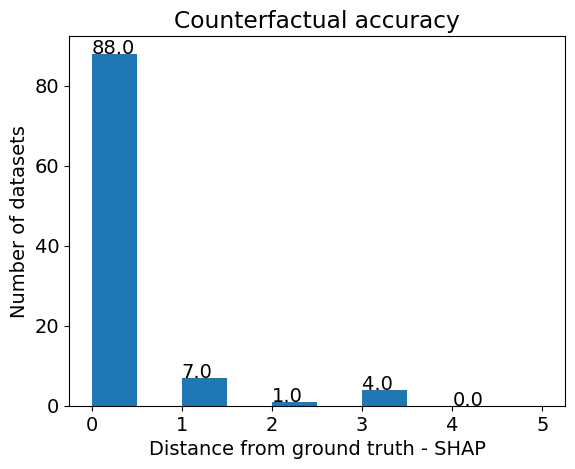

In [38]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 14})

your_bins=10
arr=plt.hist(diffs_shap,bins=your_bins, range=[0, 5])
for i in range(your_bins):
    if (i%2==0):
        plt.text(arr[1][i],arr[0][i],str(arr[0][i]))
plt.ylabel('Number of datasets')
plt.xlabel('Distance from ground truth - SHAP');
plt.title("Counterfactual accuracy")

plt.savefig("accuracy_of_counter_factual_shap.png")

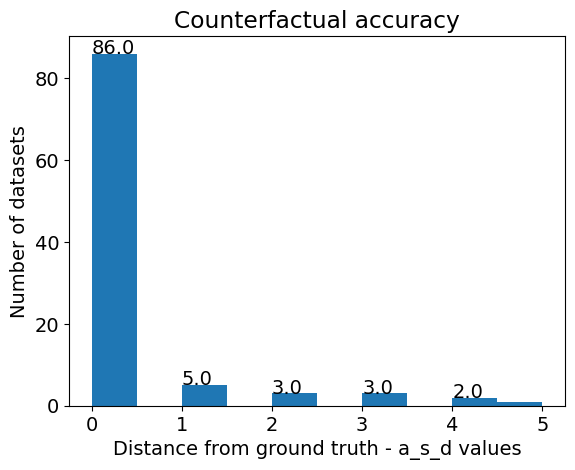

In [39]:

plt.rcParams.update({'font.size': 14})

your_bins=10
arr=plt.hist(diffs_a_s_d,bins=your_bins, range=[0, 5])
for i in range(your_bins):
    if (i%2==0):
        plt.text(arr[1][i],arr[0][i],str(arr[0][i]))
plt.ylabel('Number of datasets')
plt.xlabel('Distance from ground truth - a_s_d values');
plt.title("Counterfactual accuracy")

plt.savefig("accuracy_of_counter_factual_a_s_d.png")

In [9]:
results

[(10,
  1,
  1,
  6,
  [(1, 10),
   (5, 10),
   (10, 10),
   (20, 11),
   (50, 7),
   (100, 6),
   (200, 6),
   (500, 7)],
  [(1, 9), (5, 6), (10, 8), (20, 6), (50, 7), (100, 7), (200, 7), (500, 7)],
  7),
 (5,
  4,
  3,
  3,
  [(1, 5), (5, 5), (10, 5), (20, 5), (50, 3), (100, 3), (200, 3), (500, 3)],
  [(1, 4), (5, 3), (10, 3), (20, 3), (50, 3), (100, 3), (200, 3), (500, 3)],
  3),
 (2,
  6,
  4,
  1,
  [(1, 3), (5, 3), (10, 2), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)],
  [(1, 3), (5, 1), (10, 1), (20, 1), (50, 1), (100, 1), (200, 1), (500, 1)],
  1),
 (4,
  5,
  3,
  2,
  [(1, 3), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)],
  [(1, 2), (5, 2), (10, 2), (20, 2), (50, 2), (100, 2), (200, 2), (500, 2)],
  2),
 (9,
  2,
  1,
  3,
  [(1, 8), (5, 7), (10, 7), (20, 9), (50, 5), (100, 5), (200, 6), (500, 5)],
  [(1, 4), (5, 6), (10, 5), (20, 5), (50, 4), (100, 4), (200, 4), (500, 5)],
  6),
 (6,
  4,
  2,
  2,
  [(1, 5), (5, 5), (10, 3), (20, 2), (50, 2), (100, 2)

In [13]:
to_plot = []
for i in results:
    gt = i[3]
    shaps = i[4]
    mcs = i[5]
    a_s_d_val = i[6]
    
    for ind in range(len(shaps)):
        cur_shap = shaps[ind]
        size = cur_shap[0]
        dist_shap = cur_shap[1] - gt
        dist_a_s_d = a_s_d_val - gt
        cur_mc = mcs[ind]
        size_mc = cur_mc[0]
        dist_mc = cur_mc[1] - gt
        to_plot.append((size, dist_shap, dist_a_s_d, dist_mc))

In [14]:
to_plot

[(1, 4, 1, 3),
 (5, 4, 1, 0),
 (10, 4, 1, 2),
 (20, 5, 1, 0),
 (50, 1, 1, 1),
 (100, 0, 1, 1),
 (200, 0, 1, 1),
 (500, 1, 1, 1),
 (1, 2, 0, 1),
 (5, 2, 0, 0),
 (10, 2, 0, 0),
 (20, 2, 0, 0),
 (50, 0, 0, 0),
 (100, 0, 0, 0),
 (200, 0, 0, 0),
 (500, 0, 0, 0),
 (1, 2, 0, 2),
 (5, 2, 0, 0),
 (10, 1, 0, 0),
 (20, 0, 0, 0),
 (50, 0, 0, 0),
 (100, 0, 0, 0),
 (200, 0, 0, 0),
 (500, 0, 0, 0),
 (1, 1, 0, 0),
 (5, 0, 0, 0),
 (10, 0, 0, 0),
 (20, 0, 0, 0),
 (50, 0, 0, 0),
 (100, 0, 0, 0),
 (200, 0, 0, 0),
 (500, 0, 0, 0),
 (1, 5, 3, 1),
 (5, 4, 3, 3),
 (10, 4, 3, 2),
 (20, 6, 3, 2),
 (50, 2, 3, 1),
 (100, 2, 3, 1),
 (200, 3, 3, 1),
 (500, 2, 3, 2),
 (1, 3, 0, 0),
 (5, 3, 0, 0),
 (10, 1, 0, 0),
 (20, 0, 0, 0),
 (50, 0, 0, 0),
 (100, 0, 0, 0),
 (200, 0, 0, 0),
 (500, 0, 0, 0),
 (1, 1, 0, 0),
 (5, 2, 0, 0),
 (10, 1, 0, 1),
 (20, 2, 0, 0),
 (50, 0, 0, 0),
 (100, 0, 0, 0),
 (200, 0, 0, 0),
 (500, 0, 0, 0),
 (1, 3, 0, 2),
 (5, 3, 0, 1),
 (10, 3, 0, 0),
 (20, 2, 0, 0),
 (50, 0, 0, 0),
 (100, 0, 0, 0),
 (

In [17]:
plotting = []
for i in sample_sizes:
    avg_list_shap = [k[1] for k in to_plot if k[0] == i]

    avg_list_a_s_d = [k[2] for k in to_plot if k[0] == i]
    avg_list_mc = [k[3] for k in to_plot if k[0] == i]
    
    plotting.append((i, np.mean(avg_list_shap), np.mean(avg_list_a_s_d), np.mean(avg_list_mc)))

In [18]:
plotting

[(1, 2.94, 0.22, 1.16),
 (5, 2.52, 0.22, 0.58),
 (10, 2.0, 0.22, 0.44),
 (20, 1.36, 0.22, 0.34),
 (50, 0.56, 0.22, 0.28),
 (100, 0.18, 0.22, 0.26),
 (200, 0.14, 0.22, 0.22),
 (500, 0.18, 0.22, 0.18)]

<Figure size 640x480 with 0 Axes>

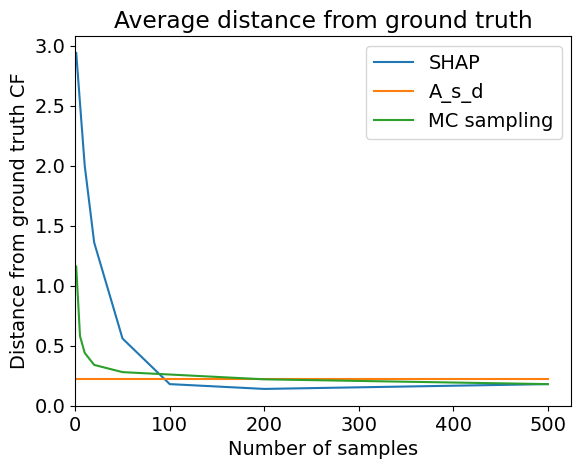

In [19]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure() 
plt.figure().clear()
plt.rcParams.update({'font.size': 14})
plt.plot([i[0] for i in plotting], [i[1] for i in plotting], label="SHAP")
plt.plot([i[0] for i in plotting], [i[2] for i in plotting], label="A_s_d")
plt.plot([i[0] for i in plotting], [i[3] for i in plotting], label="MC sampling")
plt.title("Average distance from ground truth")
plt.xlabel("Number of samples")
plt.ylabel("Distance from ground truth CF")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.legend()
plt.savefig("counter_factual_accuracy.png")
plt.show()